<a href="https://colab.research.google.com/github/mdstev1/NewRepository/blob/master/Data_Imputation_Compiled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Groundwater Data Imputation and Interpolation Script

#####This notebook contains a machine learning algorithm designed to impute data within a set of groundwater wells. The data can then be spatially interpolated to create a groundwater surface raster. Finally, a storage depletion curve can be calculated.

#####It requires as input: 
* an aquifer shapefile
* well locations and observational measurements
* PDSI and GLDAS datasets (link in script)

##### You will also need access to a Google Drive account.



---

<a name="loadUtils"></a>
## **Step 0: Load packages and files**
*This section should be run whenever a new session is started.*

### <font color='dimgray'>Install and load packages and utility files</font>

In [ ]:
#@markdown ### **Run this cell to install the proper packages**
%%capture
!pip install fiona
!pip install rasterio
!pip install h5py
!pip install geopandas
!pip install grids
!pip install scikit-learn
!pip install EMD-signal
!pip install tables
!pip install pickle5
!pip install gstools
!pip install img2pdf

In [ ]:
#@markdown ### **Run this cell to import all necessary packages to the session**

from google.colab import files, drive
import os
import ipywidgets as widgets
import shutil
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from PyEMD import EEMD
import ee
import numpy as np
import math
import sys
import datetime
import pickle
import netCDF4 as nc
from tqdm import tqdm
from datetime import timedelta
from time import time
import grids

In [ ]:
#@markdown ### **Run this cell to import the utility files from Github**
#@markdown ##### *You may need to run this cell twice if you get an error*

# Importing utility files from github
import requests
usd_url ='https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_satellite_data.py'
wf_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_well_data.py'
da_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_data_augmentation.py'
ml_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_machine_learning.py'
sp_url = 'https://raw.githubusercontent.com/Saul-the-engineer/Well_Imputation/master/Master%20Code/utils_spatial.py'
url_set = [usd_url, wf_url, da_url, ml_url, sp_url]

# Load the utility files into the session
for url in url_set:
  r = requests.get(url)
  with open(url.rsplit('/', 1)[-1], 'w') as f:
    f.write(r.text)

import utils_satellite_data as usd
import utils_well_data as wf 
import utils_data_augmentation
import utils_machine_learning
import utils_spatial
!mkdir Aquifer_Shapes Aquifers_Data Datasets

/usr/local/lib/python3.7/dist-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


### <font color='dimgray'>Load aquifer shapefile</font>

In [ ]:
#@markdown ### **Run this cell to load the aquifers shapefile**

print("Upload the aquifer shapefile files (including .shp, .shx, .prj, and .dbf):\n")
uploaded = files.upload()
for aqFile in uploaded.keys():
  os.rename('/content/'+aqFile,'/content/Aquifer_Shapes/'+aqFile)

---

## **Table of Contents**
Follow links to jump to specific sections

* [Step 0: Load packages and files](#loadUtils)
* [Step 1: Satellite Data Preparation](#satData)
* [Step 2: Prepare Wells Data for Imputation](#prep)
* [Step 3: Impute Data](#impute)
* [Step 4: Spatial Interpolation](#spatial)
* [Step 5: Storage Depletion Calculation](#storage)

<a name="satData"></a>
## **Step 1: Satellite Data Preparation**

**The PDSI and GLDAS datasets are provided via a shared Google Drive folder, found here:**
https://drive.google.com/drive/folders/1hSN6gkp9zmFYUwMOdDIj8pa-KqBjN8JW?usp=sharing

*You should save a shortcut to your own Google Drive and then determine the file path to the folder.*

In [ ]:
#@markdown ### **Run this cell to mount your Google Drive to access PDSI and GLDAS files**
drive.mount('/content/drive')

In [ ]:
#@markdown ### **Run the cell and define the path to the Satellite Data * folder ***

def saveText(button):
  global satDataPath
  satDataPath = satDataPath_widget.value
  print('\rPath to Groundwater_Imputation_-_Satellite_Data FOLDER: "%s"' %(satDataPath), end='')

satDataPath_widget = widgets.Text(placeholder='File path to Satellite Data', description='File path:', disabled=False)
button = widgets.Button(description='Save', disabled=False)
button.on_click(saveText)
print('File path to Groundwater_Imputation_-_Satellite_Data folder (not an individual file)\n(e.g. /content/drive/MyDrive/Groundwater_Imputation_-_Satellite_Data)\n\n*Tip: you can navigate to the folder on your Google Drive from the "Files" panel on the left and click on the three dots next to the folder and select "Copy path"\n')
widgets.VBox([satDataPath_widget, button])

### <font color='dimgray'>PDSI Data Prep</font>

In [ ]:
#@markdown ### **Run this cell to parse the PDSI data**

# Purpose of this script is to: 
# 1) Create a grid in the likeness of the netcdf we're interested in querying.
# 2) Using the grid, identify which cells are located within a shape file boundary.
# 3) Use the grids package, and to query the time series, for the variables and cells
#    the user has specified.
# 4) Save data as a pickle file.

# Set data location. If location does not exist, class initialization will create it.
data_root = '/content/Datasets/'
ts_date_start = '1850-01-01'

# Class initialization, imports methods and creates data_root if it doesn't exist.
utils = usd.utils_netCDF(data_root)
# Create grid based on netcdf metadata. Inputs are NE_lat, SW_lat, NE_lon, SW_lon
# x resolution, and y resolution. Calculates the centroids.
grid = utils.netCDF_Grid_Creation(77.5, -60.0, 180.0, -180.0, 2.5, 2.5)
# Loads shape file and obtains bounding box coordinates.
bounds = utils.Shape_Boundary('/content/Aquifer_Shapes/' + aqFile[:-4] + '.shp')
# Loop through grid determining if centroid is within shape boundary. Returns 
# boolean. Hyper-paramters include buffering and padding. Buffer is half cell size
# used to make sure approproate cells are captured.
cell_names = utils.Find_intercepting_cells(grid, bounds)
# Select intercepting cells from dictionary.
mask = utils.Cell_Mask(cell_names, grid)
# Create index from starting date until X weeks from present day.
dates = utils.Date_Index_Creation(ts_date_start)

# The grids_netCDF class is used to handle either the GLDAS or SC PDSI PM dataset
# The file structures are very different. Areas that have missing values, GLDAS
# will treat as NAN, while pdsi treats as mask 'None'. PDSI is a single variable file
# while GLDAS is a multi-variable file per month.

# File_String refers to the data being located with a single string, or list of strings
# Variable String, referes to the variables being within a string or text file.
parse = usd.grids_netCDF(File_String=True, Variable_String=True)

#====================================================================
# Location of single netCDF file.
data_path = satDataPath + '/PDSI/sc_PDSI_pm/pdsi_ramirez_hales_williams_1850-2020.nc4'
#====================================================================

# Name of variables of interest within file.
variables = 'sc_PDSI_pm_filled'

# Parse_Data is a nested loop using the grids python package. For every cell, grabs
# every specified variable. Then parses the variable assigning it to the correct cell
# For PDSI use Mask, dates, data_path, and variable name.

#   Mask: dictionary with locations. 
#   dates: datetimeindex, used to index dataframe
#   data_path: Location of netcdf if it is a single file, else None
#   variable_name: Names of variables wanted parse. 

Data = parse.Parse_Data(mask, dates, data_path = data_path, variable_name=variables)

# Validates that all data exists, removes nans and Nones from time series,
# as well as the location dataframe.
Data = parse.Validate_Data(mask, Data)
#print(Data.keys())
# Final Save.
utils.Save_Pickle(Data,'PDSI_Data', data_root)
print('\nSuccess!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download PDSI pickle files to local machine**
files.download('/content/Datasets/PDSI_Data.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###  <font color='dimgray'>EEMD Feature Creation from PDSI</font>

In [ ]:
#@markdown ### **Run this cell to create PDSI Intrinsic Mode Functions (IMFs) using EEMD**

# The purpose of this script is to load data and calculate intrinsic mode functions
# (imfs) and coressponding residual using Ensemble Empirical Mode Decomposition 
# (EEMD). This analysis decomposes a signal into components that create time 
# aspect for original signal. This accounts for much of the groundwater accuracy.

# Data Locations
data_root ="./Datasets/"
figures_root = './Figures EEMD'

# Importing well object class
DA = utils_data_augmentation.Data_Augmentation(data_root, figures_root)

# Load pickle Data
Data = DA.read_pickle('PDSI_Data', data_root)
cell_names = list(Data.keys())
cell_names.remove('Location')


# Code is flexible enough to handle multiple cells with multiple variables
# such as GLDAS. That is why we use nested loop even though PDSI is a single
# variable. Load cell.
loop = tqdm(total = len(cell_names), position = 0, leave = False)
for i, cell in enumerate(cell_names):
    data_temp = Data[cell]
    
    # Load EEMD class.
    for j, var in enumerate(data_temp.columns):
        if __name__ == "__main__":
            eemd = EEMD(trials = 1000, noise_width = 0.05, ext_EMD=None, 
                        parallel=False, separate_trends=False)
            eemd.noise_seed(42)
            eIMF = eemd(data_temp[var].values).T #Transverse to match with index

        # Convert pdsi EEMD numpy array to Pandas Dataframe to keep indecies.
        eIMF = pd.DataFrame(eIMF, index=data_temp.index)
        label = [var + '_imf_' + str(k+1) for k in range(len(eIMF.columns))]
        eIMF = eIMF.set_axis(label, axis=1, inplace=False)
        data_temp = data_temp.join(eIMF, how='outer')
        
        # Replace cell data with recalculated values        
        Data[cell] = data_temp
        
        # Plot EEMD Results
        fig, axs = plt.subplots(nrows= eIMF.shape[1]+1, ncols=1, figsize=(12,18))
        fig.suptitle(str('Ensemble Empirical Mode Decomposition: ' + cell +' ' + var))
        plt.subplots_adjust(top=.95, hspace=0.25)
        plot_labels = ['IMF '+str(k) if k>0 else var for k in range(len(data_temp.columns))]
        for k, _ in enumerate(data_temp):
            axs[k].plot(data_temp.index, data_temp[data_temp.columns[k]])
            axs[k].set(ylabel = plot_labels[k])
        plt.show()
        
        # Save Figure
        fig_namepng = figures_root + '/' + str(cell) + '_EEMD' + '.png'
        fig.savefig(fig_namepng, format="png", dpi=600 )
    loop.update(1)
loop.close()
# Save pickle file
DA.Save_Pickle(Data, 'PDSI_Data_EEMD')

print('Success!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the PDSI EEMD pickle file to local machine**
files.download('/content/Datasets/PDSI_Data_EEMD.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### <font color='dimgray'>GLDAS Data Prep</font>

This step will take 30-60 mins. As such, it is recommended that you set your computer settings to not go to sleep or open a program (e.g. YouTube) that will keep it awake for the full time. The files generated by this step will automatically download so that you can re-upload to your Colab session afterwards.

In [ ]:
#@markdown ### **Run this cell to parse the GLDAS data**

# Purpose of this script is to: 
# 1) Create a grid in the likeness of the netcdf we're interested in querying.
# 2) Using the grid, identify which cells are located within a shape file boundary.
# 3) Use the grids package, and to query the time series, for the variables and cells
#    the user has specified.
# 4) Save data as a pickle file.

# data_root is the location where data will be saved
data_root = '/content/Datasets/'
file_list = satDataPath + '/Sat_Data_Prep_Ref_Files/subset_GLDAS_NOAH025_M_2.0_20210628_013227.txt'

# shape_location is the location to the Shape file
shape_location = '/content/Aquifer_Shapes/' + aqFile[:-4] + '.shp'
# gldas_root is the location of folder containing the tabulated GLDAS
gldas_root = satDataPath + r'/GLDAS_Tabular'

# variables_list_loc the text file containing the GLDAS variable names
variables_list_loc = satDataPath + '/Sat_Data_Prep_Ref_Files/variables_list.txt'

# Class initialization, imports methods and creates data_root if it doesn't exist.
utils = usd.utils_netCDF(data_root)
# Create grid based on netcdf metadata. Inputs are NE_lat, SW_lat, NE_lon, SW_lon
# x resolution, and y resolution. Calculates the centroids.
grid = utils.netCDF_Grid_Creation(89.875, -59.875, 179.875, -179.875, 0.25, 0.25)
# Loads shape file and obtains bounding box coordinates.
bounds = utils.Shape_Boundary(shape_location)

# Loop through grid determining if centroid is within shape boundary. Returns 
# boolean. Hyper-paramters include buffering and padding. Buffer is half cell size
# used to make sure approproate cells are captured.
cell_names = utils.Find_intercepting_cells(grid, bounds)
# Select intercepting cells from dictionary.
mask = utils.Cell_Mask(cell_names, grid)
# Construct list of cell names within shapefile
cell_names = list(cell_names.keys())
# Create GLDAS Parsing class
GLDAS_parse = usd.GLDAS_parse(gldas_root, cell_names)
# Open variable text file, load data, convert to list
variables_list = GLDAS_parse.Variable_List(variables_list_loc)
# Create subset of GLDAS variable columns based on mask
Variable_Dictionary = GLDAS_parse.Open_GLDAS(variables_list, mask)
# Split variables into cells and store them into a dictionary along with location
Data = GLDAS_parse.parse(Variable_Dictionary, mask)
print(Data.keys())

# Save data
utils.Save_Pickle(Data,'GLDAS_Data', data_root)

print('Success!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download GLDAS pickle files to local machine**
files.download('/content/Datasets/GLDAS_Data.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### <font color='dimgray'>GLDAS Data Augment</font>

In [ ]:
#@markdown ### **Run this cell to augment the GLDAS data with forward rolling windows of 1, 3, and 5 years**
# This script will calculate modifications to datasets. Particularly this
# loads the GLDAS Data pickle file, and performs a forward rolling window.
# This will cause the data to lose months of data equivalating to the largest
# window size. 

# Importing well object class
DA = utils_data_augmentation.Data_Augmentation(figures_root = '/content')

# Load GLDAS Data
Data = DA.read_pickle('GLDAS_Data', root = './Datasets/')
cell_names = list(Data.keys())
cell_names.remove('Location') # Remove location

# Loop through every cell in the dataset performing augmentations. We only used
# FRWA, however, offsets and cumulative averages are available.
for i, cell in enumerate(cell_names):
    data_temp = Data[cell] 
    data_temp = DA.Rolling_Window(data_temp, data_temp.columns, years=[1, 3, 5])
    Data[cell] = data_temp

# Save Data
DA.Save_Pickle(Data, 'GLDAS_Data_Augmented')

print('Success!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the well pickle file and well points h5 file to local machine**
files.download('/content/Datasets/GLDAS_Data_Augmented.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

### <font color='dimgray'>EEMD Feature Creation from GLDAS</font>

In [ ]:
# The purpose of this script is to load data and calculate intrinsic mode functions
# (imfs) and coressponding residual using Ensemble Empirical Mode Decomposition 
# (EEMD). This analysis decomposes a signal into compents that create time 
# aspect for original signal. This accounts for much of the groundwater accuracy.

startTime = time()
# Data Locations
data_root ="./Datasets/"
figures_root = './Figures EEMD'
plot = True

# Importing well object class
DA = utils_data_augmentation.Data_Augmentation(data_root, figures_root)

# Load pickle Data
Data = DA.read_pickle('GLDAS_Data', data_root)
cell_names = list(Data.keys())
cell_names.remove('Location')

# Code is flexible enough to handle multiple cells with multiple variables
# such as GLDAS. That is why we use nested loop even though PDSI is a single
# variable. Load cell.
loop = tqdm(total = len(Data), position = 0, leave = False)
for i, cell in enumerate(cell_names):
    data_temp = Data[cell]

    # Load EEMD class.
    for j, var in enumerate(data_temp.columns):
        try:
            if __name__ == "__main__":
                eemd = EEMD(trials= 1000, 
                            noise_width = 0.05, 
                            ext_EMD=None, 
                            separate_trends= True,
                            DTYPE = np.float16,
                            spline_kind='akima',
                            parallel = True,
                            processes = 14)
                eemd.noise_seed(42)
                # Convert pdsi EEMD numpy array to Pandas Dataframe to keep indecies.
                eIMF = eemd(data_temp[var].values).T #Transverse to match with index
                out = pd.DataFrame(eIMF, index=data_temp.index)
                label = [var + '_imf_' + str(k+1) for k in range(len(out.columns))]
                out.columns = label
                # Replace cell data with recalculated values  
                data_temp = pd.concat([data_temp, out], join='outer', axis=1)
                Data[cell] = data_temp

                if plot:
                    # Plot EEMD Results
                    eIMF = pd.concat([data_temp[var], out], join='outer', axis=1)
                    fig, axs = plt.subplots(nrows= eIMF.shape[1], ncols=1, figsize=(12,18))
                    fig.suptitle(str('Ensemble Empirical Mode Decomposition: ' + cell +' ' + var))
                    plt.subplots_adjust(top=.95, hspace=0.25)
                    plot_labels = ['IMF '+str(k) if k>0 else var for k in range(len(eIMF.columns))]
                    for k, _ in enumerate(eIMF):
                        axs[k].plot(data_temp.index, eIMF[eIMF.columns[k]])
                        axs[k].set(ylabel = plot_labels[k])

                    # Save Figure
                    fig_namepng = figures_root + '/' + str(cell) + '_' + var + '_EEMD' + '.png'
                    fig.savefig(fig_namepng, format="png", dpi=600 )
                    plt.show()
        except Exception as e:
            print(e)

    loop.update(1)

loop.close()

# Save pickle file
DA.Save_Pickle(Data, 'GLDAS_EEMD')
executionTime = (time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

---

<a name="prep"></a>
## **Step 2: Wells Data Preparation**


[Load packages and utility files, if necessary](#loadUtils)

In [ ]:
#@markdown ### **Select pickle option below and run this cell to create/load your pickle file**
#@markdown ##### *Select your pickle creation/upload option below*
Pickle_Upload_Type = "2) Upload an existing pickle file from Google Drive (recommended for 100+ MB files)" #@param ["1) Create your pickle file", "2) Upload an existing pickle file from Google Drive (recommended for 100+ MB files)", "3) Upload existing pickle file from computer"]
# Load data pickle (it must contain 3 df's: centroid of wells, well locations, well measurements)
if Pickle_Upload_Type[0:1] == '1':
  print('Proceed to next section.')
elif Pickle_Upload_Type[0:1] == '2':
  def saveText(button):
    global pickleFilePath
    pickleFileOriginal = pickleFilePath_widget.value
    pickleFilePath = '/content/Aquifers_Data/' + pickleFileOriginal.rsplit('/', 1)[-1]
    print('\rPickle File: "%s" copied to "%s"' %(pickleFileOriginal, pickleFilePath), end='')
    shutil.copy(pickleFileOriginal, pickleFilePath)
  drive.mount('/content/drive')
  !mkdir Aquifer_Shapes Aquifers_Data Datasets
  pickleFilePath_widget = widgets.Text(placeholder='Path to File', description='File Path:', disabled=False)
  button = widgets.Button(description='Save', disabled=False)
  button.on_click(saveText)
  print('Specify the path to your pickle file\n(hint: navigate to your file using the files panel on the left, then click "copy path"')
  display(widgets.VBox([pickleFilePath_widget, button]))
else:
  print("Upload the pickle file with well locations, centroid, and time series measurements:\n")
  uploaded = files.upload()
  data_file = ''.join(uploaded)
  os.rename('/content/'+data_file,'/content/Aquifers_Data/'+data_file)
  pickleFilePath = '/content/Aquifers_Data/'+data_file

### <font color='dimgray'>Wells Data - Pickle File Creation (if necessary)</font>
If you need to create a pickle file from csv file(s), this section can be used for preparing a pickle file for wells data preparation. It requires a wells file and a time series file as inputs (.csv files) and creates one output file (.pickle). If you have already uploaded an existing pickle file, you can skip this subsection and go to the 'Wells Data Prep' subsection.

In [ ]:
#@markdown ### **Select upload options and run the cell to create a pickle file from existing csv files**
#@markdown *You can upload a single file, or upload both a wells and a time series file*
upload_a_wells_file = True #@param {type:"boolean"}
upload_a_timeseries_file = True #@param {type:"boolean"}
#@markdown *If a pickle file has already been created, you can skip this section and upload it in the next section (Wells Data Prep)*
if Pickle_Upload_Type[0:1] != '1':
  sys.exit("'Upload pickle file' option selected in last cell. If you need to create your pickle file, return to the last cell and select the appropriate option. Otherwise, proceed to next section.")

def uploadFile(ftype):
  print("Upload your %s csv file\n" %ftype)
  uploaded = files.upload()
  newfile = ''.join(uploaded)
  df = pd.read_csv(newfile)
  return df

def saveHeaders(button):
  global wls_wellID, lat, long, tms_wellID, date, var
  wls_wellID, lat, long, tms_wellID, date, var = wls_wellID_widget.value, lat_widget.value, long_widget.value, tms_wellID_widget.value, date_widget.value, var_widget.value
  print('\rWell ID column (wells file) = "%s", Latitude column = "%s", Longitude column = "%s" Well ID column (time series file) = "%s", Date column = "%s", Variable column = "%s"' %(wls_wellID, lat, long, tms_wellID, date, var), end='')

def Pandas_to_Pickle(combined_df, location_df, centroid, name):
    Aquifer = {'Data':combined_df, 'Location':location_df, 'Centroid':centroid}
    pickle_name = name + '.pickle'
    with open(pickle_name, 'wb') as handle:
        pickle.dump(Aquifer, handle)
    return Aquifer

# Upload csv files and select headers
if upload_a_wells_file == True: wls_df = uploadFile('wells')
if upload_a_timeseries_file == True: tms_df = uploadFile('time series')

if upload_a_wells_file == True: wList = wls_df.columns
else: wList = tms_df.columns
if upload_a_timeseries_file == True: tList = tms_df.columns
else: tList = wls_df.columns

wls_wellID_widget = widgets.Dropdown(options=wList, description = "Well ID")
lat_widget = widgets.Dropdown(options=wList, description = "Latitude")
long_widget = widgets.Dropdown(options=wList, description = "Longitude")
tms_wellID_widget = widgets.Dropdown(options=tList, description = "Well ID")
date_widget = widgets.Dropdown(options=tList, description = "Date")
var_widget = widgets.Dropdown(options=tList, description = "Measurement")
button = widgets.Button(description='Save', disabled=False)
button.on_click(saveHeaders)

print("\n\nSpecify the column headers for your wells and/or time series files and save\n")
wls_grid = widgets.VBox([wls_wellID_widget, lat_widget, long_widget])
tms_grid = widgets.VBox([tms_wellID_widget, date_widget, var_widget])
widgets.GridBox(
     [ widgets.Label(value='Wells File headers:'), wls_grid, 
       widgets.Label(value='Time Series File headers:'), tms_grid, button ], 
     layout=widgets.Layout(grid_template_columns="repeat(4, 300px)")
     )

Upload your wells csv file



Saving Master_Stations_CV.csv to Master_Stations_CV.csv
Upload your time series csv file



Saving Master_Measurements_CV.csv to Master_Measurements_CV.csv


Specify the column headers for your wells and/or time series files and save



GridBox(children=(Label(value='Wells File headers:'), VBox(children=(Dropdown(description='Well ID', options=(…

Well ID column (wells file) = "Well_ID", Latitude column = "lat", Longitude column = "lon" Well ID column (time series file) = "Well_ID", Date column = "date", Variable column = "WTE"

In [ ]:
#@markdown ### **Define the file name of the pickle file that will be created, then run the cell**
picklefilename = 'CA_JPL' #@param {type:"string"}

# Set the dates as dates and sort in ascending order
tms_df[date] = pd.to_datetime(tms_df[date])
tms_df.sort_values(by=[date], inplace=True)

numWells = len(tms_df.drop_duplicates([tms_wellID]))
numDates = len(tms_df.drop_duplicates([date]))
numDups = len(tms_df.drop_duplicates([tms_wellID, date]))
#print('There are %d unique wells, %d unique dates, and %d unique entries (with a unique well ID and date combo).' % (numWells, numDates, numDups))
#print('The shape of the matrix:' + ' ' + str(tms_df.shape))

# Create the NxM matrix (where N = number of unique dates with values; M = number of unique well IDs)
tms_df_matrix = pd.pivot_table(tms_df, index=date, values=var, columns=tms_wellID)
#print(sum(tms_df_matrix.count()), "values in the matrix\n(Values from the same well and date are averaged)\n")
#print('The shape of the matrix: %s' %str(tms_df_matrix.shape))

# Create locations df
unique_wells_df = wls_df.drop_duplicates(wls_wellID).merge(tms_df.drop_duplicates(tms_wellID)[tms_wellID], left_on=wls_wellID, right_on=tms_wellID)
unique_wells_df.rename(columns={long: "Longitude", lat: "Latitude"}, inplace=True)
unique_wells_df = unique_wells_df[[wls_wellID, 'Latitude', 'Longitude']].set_index(wls_wellID)

# Calculate centroid
centroid_df = pd.DataFrame([0,0], index=(['Longitude','Latitude']))
lonAvg, latAvg = unique_wells_df['Longitude'].mean(), unique_wells_df['Latitude'].mean()
centroid_df.loc['Longitude'], centroid_df.loc['Latitude'] = lonAvg, latAvg

pickleData = Pandas_to_Pickle(tms_df_matrix, unique_wells_df, centroid_df, picklefilename)
pickleFilePath = '/content/Aquifers_Data/'+picklefilename+'.pickle'
os.rename('/content/'+picklefilename+'.pickle', pickleFilePath)

### <font color='dimgray'>Wells Data Prep</font>

In [ ]:
#@markdown ### **Run this cell to filter, resample, and interpolate observed well data**
#@markdown ---
#@markdown #### Specify minimum number of unique observation months
#@markdown *In order to filter out wells that do not have sufficient data, a minimum number of unique observation months (i.e. unique months with at least 1 observation) is required.* **All wells that do not meet this threshold will be discarded.**
Minimum_Observation_Months = 150 #@param {type:"integer"}
#@markdown #### Specify the date range
#@markdown *Measurements taken before outside this range will not be considered in the minimum observation month filtering*
Start_Year = 2002 #@param {type:"integer"}
End_Year = 2021 #@param {type:"integer"}
#@markdown ---
#@markdown #### Specify the pad size
#@markdown *The pad size determines the length of time (in days) after an observation that data will be interpolated*
Pad_Size = 90 #@param {type:"integer"}
 
# This script opens preprocessed pickle file containing 3 DataFrames: Centroid,
# Well Timeseries, and well location.
# High level does 3 things:
# 1: Extracts Well Time series, and drops any well without a minimum amount
#    of Data within a user specified window
# 2: Interpolates subset of data, removing gaps larger than user specified size
#    Gaps will be filled in using a machine learning algorithm. This step
#    is based on the assumption that groundwater changes are slow, and readings
#    will remain valid for a time period after the original reading.
# 3: Contains support functions of data augmentation such as Rolling-Window 
#    averages and plotting. 

# Data Locations
data_root =    '/content/Datasets/'
aquifer_root = '/content/Aquifers_Data'
figures_root = '/content/Figures Aquifer'

# Location must be added
Wells = wf.wellfunc(data_root, aquifer_root, figures_root)

# read the well data from a pickle file
raw_wells_dict = Wells.read_well_pickle(pickleFilePath.rsplit('/', 1)[-1][:-7])

# extractwelldata extracts waterlevel measurements and creates a panda data 
# Bcap and Fcap are bottom and final cap, this control guarrenties that wells
# will contain data before and after the caps
# MinEx is the minimum number examples required within dataset
# extract the data into a panda data frame
wells_dict = Wells.extractwelldata(raw_wells_dict, Left=Start_Year, Right=End_Year, Min_Obs_Months=Minimum_Observation_Months, outlier = 3)          

# now need to resample well data to begining of month ('1MS') or chosen period
# next most used will be 'QS' Quarter Start Frequency
# need to fill with NaNs on large gaps
# interpolate the well data to regular interval
# do not interpolate for large gaps (gap size can be set in function)
# provide data on either side of measured data - no nans - can be set in func
# can select data interval in function pad 90, 180, 120
wells_dict['Data'] = Wells.interp_well(wells_dict['Data'], gap_size = '365 days', pad = Pad_Size, spacing = '1MS')

# Plot Well Results
Wells.well_plot(wells_dict['Data'], wells_dict['Data'], plot_wells= True)  # plot the data to look at

#Save Datasets
Wells.Save_Pickle(wells_dict, 'Well_Data')
wells_dict['Data'].to_hdf(data_root + '03_Original_Points.h5', key='df', mode='w')

print('Success!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the well pickle file and well points h5 file to local machine**
#@markdown ##### *You may have to [allow colab to download multiple files at a time](#download)*
files.download('/content/Datasets/Well_Data.pickle')
files.download('/content/Datasets/03_Original_Points.h5')

---

<a name="impute"></a>

## **Step 3: Data Imputation**

This step may take anywhere from a few minutess to a few hours, depending on how many wells you have (that weren't filtered out).

We recommend that when you run each cell, you also run the optional file download cell at the end of the section so that you don't lose your work.

[Load packages and utility files](#loadUtils)

In [ ]:
#@markdown ### **Run this cell to load a new environment to perform data imputation**
import utils_machine_learning
import warnings
from scipy.spatial.distance import cdist
import random
from scipy.stats import pearsonr
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
# from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression

from tensorflow.random import set_seed
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import RootMeanSquaredError

print('Success!')

Success!


In [ ]:
#@markdown ### **Run this cell to upload files (if starting from a new session)**
Upload_Files = False #@param {type:"boolean"}

if Upload_Files == True:
  if not os.path.isdir('Datasets'):
    !mkdir Datasets
  print("Upload Well_Data pickle file from step 2\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  print("\nUpload 03_Original_Points.h5 file from step 2\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  print("\nUpload PDSI_Data_EEMD pickle file from step 1\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  print("\nUpload GLDAS_EEMD pickle file from step 1\n(The file may take several minutes to upload)\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
else: print("If your files are not uploaded in the current session, select the Upload_Files box and re-run the cell.")

If your files are not uploaded in the current session, select the Upload_Files box and re-run the cell.


### I. Satellite-Based Imputation

In [ ]:
warnings.simplefilter(action='ignore')
np.random.seed(42)
set_seed(seed=42)

#Data Settings
#@markdown ### **Define the name of the aquifer, then run the cell**
aquifer_name = "Central Valley, CA" #@param {type:"string"}
data_root =    '/content/Datasets/'
figures_root = '/content/Figures Imputed'
#@markdown ---
#@markdown ##### Specify whether a test set should be used. Without a test set, the data will be split into training data and validation data. A test set provides a more robust way of testing the data, but requires more observed data to be available.
test_set = True #@param {type:"boolean"}
val_split = 0.30

errors = []
###### Model Setup
imp = utils_machine_learning.imputation(data_root, figures_root)

###### Measured Well Data
Original_Raw_Points = pd.read_hdf(data_root + '03_Original_Points_50_120.h5')
Well_Data = imp.read_pickle('Well_Data_50_120', data_root)
PDSI_Data = imp.read_pickle('PDSI_Data_EEMD', data_root)
GLDAS_Data = imp.read_pickle('GLDAS_EEMD_Combined', data_root)

###### Getting Well Dates
Start_Date = "1960-01-01" #@param {type:"date"}
End_Date = "2021-01-01" #@param {type:"date"}
# Feature_Index = GLDAS_Data[list(GLDAS_Data.keys())[0]].index
Feature_Index = pd.date_range(start=Start_Date, end=End_Date, freq='MS')

###### Importing Metrics and Creating Error DataFrame
columns = ['Train ME',     'Train RMSE',      'Train MAE',      'Train Points',      'Train r2',
           'Validation ME','Validation RMSE', 'Validation MAE', 'Validation Points', 'Validation r2',
           'Test ME',      'Test RMSE',       'Test MAE',       'Test Points',       'Test r2',
           'Comp R2']
Summary_Metrics = pd.DataFrame(columns = columns)

###### Feature importance Tracker
Feature_Importance = pd.DataFrame()

###### Creating Empty Imputed DataFrame
Imputed_Data = pd.DataFrame(index=Feature_Index)

In [ ]:
# Original_Raw_Points.drop('361334120035101', axis=1, inplace=True)
# Well_Data['Data'].drop('361334120035101', axis=1, inplace=True)
# Well_Data['Location'].drop('361334120035101', axis=0, inplace=True)

In [ ]:
# @markdown ### **Specify your run option and parameters and run this cell to perform data imputation using the machine learning algorithm**
# @markdown #### * *Please note that this step will take a long time. We recommend to [allow Colab to download multiple files at once](#download), then run the subsequent cell at the same time as this cell. That will automatically download your files  after imputation is complete in case your Colab session ends before you return.* *
# @markdown ---
# @markdown *The default option is a lighter version that does not include K-fold cross-validation. You can change that option here:*
Validation_Type = "2) Advanced (with K-fold cross-validation)" #@param ["1) Basic (default)", "2) Advanced (with K-fold cross-validation)"]
# @markdown ---
# @markdown #### Specify the L2 Parameter:
# @markdown *L2 is a parameter for regularization... the higher the value, the more smooth or biased it is*
L2_Parameter = 0.1 #@param {type:"number"} 
# default 0.01
# @markdown ---
# @markdown #### Specify the Test Size Parameter:
# @markdown *Specify the start year and the gap length (in years)*
Test_Start_Year = None #@param {type:"raw"} 
Test_Gap_Length =  3#@param {type:"number"} 


###### Starting Learning Loop
loop = tqdm(total = len(Well_Data['Data'].columns), position = 0, leave = False)

for i, well in enumerate(Well_Data['Data'].columns):
    try:
        # Get Well raw readings for single well
        y_raw = Original_Raw_Points[well].fillna(limit=2, method='ffill')

        # Get Well readings for single well
        y_well = pd.DataFrame(Well_Data['Data'][well], index = Feature_Index[:])

        # Add Dumbies
        table_dumbies = pd.get_dummies(Feature_Index.month_name())
        table_dumbies.index = Feature_Index
        table_dumbies['Months'] = (Feature_Index - Feature_Index[0]).astype(int)
        table_dumbies['Months'] = table_dumbies['Months']/table_dumbies['Months'][-1]

        # Create Well Trend
        windows = [6, 12, 36, 60]
        shift = int(max(windows)/2)
        weight = 1.5
        pchip, x_int_index, pchip_int_index  = imp.interpolate(Feature_Index, y_raw, well, shift = shift)
        slope, y_int, reg_line = imp.linear_regression(x_int_index, pchip.dropna())
        linear_extrap = imp.linear_extrapolation(x_int_index, pchip)
        trend, slopes_L, slopes_R  = imp.linear_correction(pchip, x_int_index, pchip_int_index, slope, linear_extrap, weight = weight)
        imp.trend_plot(y_raw, pchip, x_int_index, slope, y_int, slopes_L, slopes_R, weight, well)
        pchip = pchip['pchip'].fillna(trend['linear'])
        rw = imp.rolling_windows(pchip, windows = windows)
        rw = rw[rw[rw.columns[-1]].notna()]
        imp.rw_plot(rw, well)
        table_rw = pd.DataFrame(rw, index=rw.index, columns = rw.columns)

        # PDSI Selection
        (well_x, well_y) = Well_Data['Location'].loc[well]
        df_temp = PDSI_Data['Location'].dropna(axis=0)
        pdsi_dist = pd.DataFrame(cdist(np.array(([well_x,well_y])).reshape((1,2)), df_temp, metric='euclidean'), columns=df_temp.index).T
        pdsi_key = pdsi_dist[0].idxmin()
        table_pdsi = PDSI_Data[pdsi_key]

        # GLDAS Selection
        df_temp = GLDAS_Data['Location'].dropna(axis=0)
        gldas_dist = pd.DataFrame(cdist(np.array(([well_x,well_y])).reshape((1,2)), df_temp, metric='euclidean'), columns=df_temp.index).T
        gldas_key = gldas_dist[0].idxmin()
        table_gldas = GLDAS_Data[gldas_key]

        # Calculate surface water
        sw_names = ['SoilMoi0_10cm_inst',
                    'SoilMoi10_40cm_inst',
                    'SoilMoi40_100cm_inst',
                    'SoilMoi100_200cm_inst',
                    'CanopInt_inst',
                    'SWE_inst']
        table_sw  = table_gldas[sw_names].sum(axis=1)
        table_sw.name = 'Surface Water'

        # Temporary merging gldas + PDSI before PCA
        Feature_Data = imp.Data_Join(table_pdsi, table_gldas).dropna()
        Feature_Data = imp.Data_Join(Feature_Data, table_rw).dropna()
        Feature_Data = imp.Data_Join(Feature_Data, table_sw).dropna()

        # Joining Features to Well Data
        Well_set = y_well.join(Feature_Data, how='outer')
        Well_set = Well_set[Well_set[Well_set.columns[1]].notnull()]
        Well_set_clean = Well_set.dropna()

        # Split Data into Training/Validation sets
        Y, X = imp.Data_Split(Well_set_clean, well)
        
        if Validation_Type[0] == '2':

            # Run feature scaler and PCA on GLDAS and PDSI Training Data
            pca_components = 25
            pca_col_names = ['PCA '+ str(comp) for comp in range(pca_components)]
            only_scale = windows + [table_sw.name]
            pca = PCA(n_components=pca_components)
            fs = StandardScaler()
            ws = StandardScaler()


            # Create number of Folds
            folds = 5
            (Y_kfold, X_kfold) = (Y.to_numpy(), X.to_numpy())
            kfold = KFold(n_splits = folds, shuffle = False)
            temp_metrics = pd.DataFrame(columns = columns)
            j = 1
            n_epochs = []
            
            # Train K-folds grab error metrics average results
            for train_index, test_index in kfold.split(Y_kfold, X_kfold):
                x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
                y_train, y_test = Y.iloc[train_index], Y.iloc[test_index,:]

                # Create validation and training sets
                x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, random_state=42)
                
                temp_out = imp.scaler_pipline(x_train, fs, pca, table_dumbies, 
                                              only_scale, pca_col_names, train=True)
                x_train, fs, pca, variance = temp_out

                # Transform validation and test sets
                x_val = imp.scaler_pipline(x_val, fs, pca, table_dumbies, 
                                          only_scale, pca_col_names, train=False)
                x_test = imp.scaler_pipline(x_test, fs, pca, table_dumbies, 
                                          only_scale, pca_col_names, train=False)
                X_pred_temp = imp.scaler_pipline(Feature_Data, fs, pca, table_dumbies, 
                                          only_scale, pca_col_names, train=False)

                # Transform Y values
                y_train = pd.DataFrame(ws.fit_transform(y_train), index = y_train.index, columns = y_train.columns)
                y_val = pd.DataFrame(ws.transform(y_val), index = y_val.index, columns = y_val.columns)
                y_test = pd.DataFrame(ws.transform(y_test), index = y_test.index, columns = y_test.columns)

                # Model Initialization
                hidden_nodes = 50
                opt = Adam(learning_rate=0.001)
                model = Sequential()
                model.add(Dense(hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                kernel_initializer='glorot_uniform', kernel_regularizer= L2(l2=L2_Parameter)))
                model.add(Dropout(rate=0.2))
                model.add(Dense(2*hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                    kernel_initializer='glorot_uniform'))
                model.add(Dropout(rate=0.2))
                model.add(Dense(1))
                model.compile(optimizer = opt, loss='mse', metrics=[RootMeanSquaredError()])

                # Hyper Paramter Adjustments
                early_stopping = callbacks.EarlyStopping(
                                    monitor='val_loss', 
                                    patience=7, 
                                    min_delta=0.0, 
                                    restore_best_weights=True)
                adaptive_lr    = callbacks.ReduceLROnPlateau(
                                    monitor='val_loss', 
                                    factor=0.1, 
                                    min_lr=0)
                history        = model.fit(
                                    x_train, 
                                    y_train, 
                                    epochs=700, 
                                    validation_data = (x_val, y_val), 
                                    verbose= 0, 
                                    callbacks=[early_stopping, adaptive_lr])

                # Score and Tracking Metrics
                y_train     = pd.DataFrame(ws.inverse_transform(y_train), index=y_train.index, 
                                          columns = ['Y Train']).sort_index(axis=0, ascending=True)
                y_train_hat = pd.DataFrame(ws.inverse_transform(model.predict(x_train)), index=x_train.index, 
                                          columns = ['Y Train Hat']).sort_index(axis=0, ascending=True)
                y_val       = pd.DataFrame(ws.inverse_transform(y_val), index=y_val.index,
                                          columns = ['Y Val']).sort_index(axis=0, ascending=True)
                y_val_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_val)), index=x_val.index,
                                          columns = ['Y Val Hat']).sort_index(axis=0, ascending=True)

                train_points, val_points = [len(y_train)], [len(y_val)]

                train_me    = (sum(y_train.values - y_train_hat.values) / train_points).item()
                train_rmse  = mean_squared_error(y_train.values, y_train_hat.values, squared=False)
                train_mae   = mean_absolute_error(y_train.values, y_train_hat.values)

                val_me      = (sum(y_val.values - y_val_hat.values) / val_points).item()
                val_rmse    = mean_squared_error(y_val.values, y_val_hat.values, squared=False)
                val_mae     = mean_absolute_error(y_val.values, y_val_hat.values)

                train_e      = [train_me, train_rmse, train_mae]
                val_e        = [val_me, val_rmse, val_mae]

                test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']

                train_errors = np.array([train_e + val_e]).reshape((1,6))
                errors_col   = ['Train ME','Train RMSE', 'Train MAE',
                                'Validation ME','Validation RMSE', 'Validation MAE']
                df_metrics   = pd.DataFrame(train_errors, index=([str(j)]), columns = errors_col)

                df_metrics['Train Points']      = train_points
                df_metrics['Validation Points'] = val_points
                df_metrics['Train r2'], _       = pearsonr(y_train.values.flatten(), y_train_hat.values.flatten())
                df_metrics['Validation r2'], _  = pearsonr(y_val.values.flatten(), y_val_hat.values.flatten())
                temp_metrics = pd.concat(objs=[temp_metrics, df_metrics])

                # Model Prediction
                Prediction_temp = pd.DataFrame(
                                ws.inverse_transform(model.predict(X_pred_temp)), 
                                index=X_pred_temp.index, columns = ['Prediction'])

                # Test Sets and Plots
                try:
                    y_test       = pd.DataFrame(ws.inverse_transform(y_test), index=y_test.index,
                                      columns = ['Y Test']).sort_index(axis=0, ascending=True)
                    y_test_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_test)), index=y_test.index, 
                                      columns = ['Y Test Hat']).sort_index(axis=0, ascending=True)
                    test_points  = len(y_test)
                    test_me      = (sum(y_test.values - y_test_hat.values) / test_points).item()
                    test_rmse    = mean_squared_error(y_test.values, y_test_hat.values, squared=False)
                    test_mae     = mean_absolute_error(y_test.values, y_test_hat.values)

                    test_errors  = np.array([test_me, test_rmse, test_mae]).reshape((1,3))
                    test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
                    test_metrics = pd.DataFrame(test_errors,
                                                index = [str(j)], 
                                                columns = test_cols)
                    test_metrics['Test Points'] = test_points
                    test_metrics['Test r2'], _  = pearsonr(y_test.values.flatten(), y_test_hat.values.flatten())
                    temp_metrics.loc[str(j), test_metrics.columns] = test_metrics.loc[str(j)]
                    plot_kfolds = False
                    imp.prediction_kfold(Prediction_temp['Prediction'], 
                                                  y_well.drop(y_test.index, axis=0),  
                                                  y_test, 
                                                  str(well) +"_kfold_" + str(j), 
                                                  temp_metrics.loc[str(j)], 
                                                  error_on = True,
                                                  plot = plot_kfolds)

                except: 
                    temp_metrics.loc[str(j), ['Test ME','Test RMSE', 'Test MAE']] = np.NAN
                    temp_metrics.loc[str(j), 'Test Points'] = 0 
                    temp_metrics.loc[str(j),'Test r2'] = np.NAN
                    imp.prediction_kfold(Prediction_temp['Prediction'], 
                                            y_well.drop(y_test.index, axis=0),
                                            y_test, 
                                            str(well) +"_kfold_" + str(j),
                                            plot = plot_kfolds)
                
                print(j)
                j += 1
                n_epochs.append(len(history.history['loss']))
                
            epochs = int(sum(n_epochs)/folds)

            # Reset feature scalers
            temp_out  = imp.scaler_pipline(X, fs, pca, table_dumbies, 
                                          only_scale, pca_col_names, train=True)
            X, fs, pca, variance = temp_out

            X_pred = imp.scaler_pipline(Feature_Data, fs, pca, table_dumbies, 
                                      only_scale, pca_col_names, train=False)
            Y = pd.DataFrame(ws.fit_transform(Y), index = Y.index, columns = Y.columns)

            # Retrain Model with number of epochs
            history = model.fit(X, Y, epochs = epochs, verbose = 0)
            metrics_avg = pd.DataFrame(temp_metrics.mean(), columns=[well]).transpose()
            Summary_Metrics = pd.concat(objs=[Summary_Metrics, metrics_avg])
            
            # y_test_hat = model.predict(x_test)
            # y_hat = y_test_hat
            # y_object = y_test
        elif Validation_Type[0] == '1':
            
            ###### Create Test Set
            y_subset, y_test, e = imp.test_range_split(
                df = Y, f_index = Feature_Index, name = well, min_points = 1, 
                cut_left = Test_Start_Year, gap_year = Test_Gap_Length, random = True, max_tries = 15, max_gap = 12)
            if e != None:
                errors.append((i, e))
                imp.log_errors(errors, 'errors', data_root)
            x_test = imp.Data_Join(y_test, X, method='inner').drop(y_test.columns, axis=1)
            x_subset = X.drop(x_test.index, axis=0)

            ###### Create training and validation set
            x_train, x_val, y_train, y_val = train_test_split(x_subset, y_subset, test_size = val_split, random_state = 42)

            ###### Run feature scaler and PCA on GLDAS and PDSI Training Data
            pca_components = min(len(x_train), 25)
            pca_col_names = ['PCA '+ str(comp) for comp in range(pca_components)]
            only_scale = windows + [table_sw.name]
            pca = PCA(n_components=pca_components)
            fs = StandardScaler()
            
            temp_out = imp.scaler_pipline(x_train, fs, pca, table_dumbies, 
                                          only_scale, pca_col_names, train=True)
            x_train, fs, pca, variance = temp_out

            ###### Transform validation and test sets
            x_val = imp.scaler_pipline(x_val, fs, pca, table_dumbies, 
                                      only_scale, pca_col_names, train=False)
            x_test = imp.scaler_pipline(x_test, fs, pca, table_dumbies, 
                                      only_scale, pca_col_names, train=False)
            X = imp.scaler_pipline(X, fs, pca, table_dumbies, 
                                      only_scale, pca_col_names, train=False)
            X_pred = imp.scaler_pipline(Feature_Data, fs, pca, table_dumbies, 
                                      only_scale, pca_col_names, train=False)   

            ###### Transform Y values
            ws = StandardScaler()
            y_train = pd.DataFrame(ws.fit_transform(y_train), index = y_train.index, columns = y_train.columns)
            y_val = pd.DataFrame(ws.transform(y_val), index = y_val.index, columns = y_val.columns)
            y_test = pd.DataFrame(ws.transform(y_test), index = y_test.index, columns = y_test.columns)
            Y = pd.DataFrame(ws.transform(Y), index = Y.index, columns = Y.columns)


            ###### Model Initialization
            hidden_nodes = 50
            opt = Adam(learning_rate=0.001)
            model = Sequential()
            model.add(Dense(hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                            kernel_initializer='glorot_uniform', kernel_regularizer= L2(l2=L2_Parameter))) 
            model.add(Dropout(rate=0.2))
            model.add(Dense(2*hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                            kernel_initializer='glorot_uniform'))
            model.add(Dropout(rate=0.2))
            model.add(Dense(1))
            model.compile(optimizer = opt, loss='mse', metrics=[RootMeanSquaredError()])
        
            ###### Hyper Paramter Adjustments
            early_stopping = callbacks.EarlyStopping(
                            monitor='val_loss', 
                            patience=7, 
                            min_delta=0.0, 
                            restore_best_weights=True)
            adaptive_lr    = callbacks.ReduceLROnPlateau(
                            monitor='val_loss', 
                            factor=0.1, 
                            min_lr=0)
            history        = model.fit(
                            x_train, 
                            y_train, 
                            epochs=700, 
                            validation_data = (x_val, y_val), 
                            verbose= 0, 
                            callbacks=[early_stopping, adaptive_lr])
            ###### Score and Tracking Metrics
            y_train     = pd.DataFrame(ws.inverse_transform(y_train), index=y_train.index, 
                                  columns = ['Y Train']).sort_index(axis=0, ascending=True)
            y_train_hat = pd.DataFrame(ws.inverse_transform(model.predict(x_train)), index=x_train.index, 
                                  columns = ['Y Train Hat']).sort_index(axis=0, ascending=True)
            y_val       = pd.DataFrame(ws.inverse_transform(y_val), index=y_val.index,
                                   columns = ['Y Val']).sort_index(axis=0, ascending=True)
            y_val_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_val)), index=x_val.index,
                                   columns = ['Y Val Hat']).sort_index(axis=0, ascending=True)

            train_points, val_points = [len(y_train)], [len(y_val)]
            
            train_me    = (sum(y_train.values - y_train_hat.values) / train_points).item()
            train_rmse  = mean_squared_error(y_train.values, y_train_hat.values, squared=False)
            train_mae   = mean_absolute_error(y_train.values, y_train_hat.values)

            val_me      = (sum(y_val.values - y_val_hat.values) / val_points).item()
            val_rmse    = mean_squared_error(y_val.values, y_val_hat.values, squared=False)
            val_mae     = mean_absolute_error(y_val.values, y_val_hat.values)

            train_e      = [train_me, train_rmse, train_mae]
            val_e        = [val_me, val_rmse, val_mae]

            test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
            
            train_errors = np.array([train_e + val_e]).reshape((1,6))
            errors_col   = ['Train ME','Train RMSE', 'Train MAE',
                            'Validation ME','Validation RMSE', 'Validation MAE']
            df_metrics   = pd.DataFrame(train_errors, index=([str(well)]), columns = errors_col)

            df_metrics['Train Points']      = train_points
            df_metrics['Validation Points'] = val_points
            df_metrics['Train r2'], _       = pearsonr(y_train.values.flatten(), y_train_hat.values.flatten())
            df_metrics['Validation r2'], _  = pearsonr(y_val.values.flatten(), y_val_hat.values.flatten())
            Summary_Metrics = pd.concat(objs=[Summary_Metrics, df_metrics])
            # y_val_hat = model.predict(x_val)
            # y_hat = y_val_hat
            # y_object = y_val

        # Combined #
        # Model Prediction
        Prediction = pd.DataFrame(
                        ws.inverse_transform(model.predict(X_pred)), 
                        index=X_pred.index, columns = ['Prediction'])

        Comp_R2    = r2_score(
                        ws.inverse_transform(Y.values.reshape(-1,1)), 
                        ws.inverse_transform(model.predict(X)))
        Summary_Metrics.loc[well,'Comp R2'] = Comp_R2
        # r2 = r2_score(well_scaler.inverse_transform(Well_set_temp.reindex(X.index).dropna(how='all')), well_scaler.inverse_transform(model.predict(X)))
        #r2 = r2_score(well_scaler.inverse_transform(Well_set_temp.dropna()), well_scaler.inverse_transform(model.predict(X)))

        if Validation_Type[0] == '1':
            ###### Test Sets and Plots
            try:
                y_test       = pd.DataFrame(ws.inverse_transform(y_test), index=y_test.index,
                                  columns = ['Y Test']).sort_index(axis=0, ascending=True)
                y_test_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_test)), index=y_test.index, 
                                  columns = ['Y Test Hat']).sort_index(axis=0, ascending=True)
                test_points  = len(y_test)
                test_me      = (sum(y_test.values - y_test_hat.values) / test_points).item()
                test_rmse    = mean_squared_error(y_test.values, y_test_hat.values, squared=False)
                test_mae     = mean_absolute_error(y_test.values, y_test_hat.values)

                test_errors  = np.array([test_me, test_rmse, test_mae]).reshape((1,3))
                test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
                test_metrics = pd.DataFrame(test_errors,
                                            index = [str(well)], 
                                            columns = test_cols)
                test_metrics['Test Points'] = test_points
                test_metrics['Test r2'], _  = pearsonr(y_test.values.flatten(), y_test_hat.values.flatten())
                Summary_Metrics.loc[well,test_metrics.columns] = test_metrics.loc[well]

                imp.prediction_vs_test(Prediction['Prediction'], 
                                              y_well.drop(y_test.index, axis=0),  
                                              y_test, 
                                              str(well), 
                                              Summary_Metrics.loc[well], 
                                              error_on = True)
            except: 
                Summary_Metrics.loc[well,['Test ME','Test RMSE', 'Test MAE']] = np.NAN
                Summary_Metrics.loc[well, 'Test Points'] = 0 
                Summary_Metrics.loc[well,'Test r2'] = np.NAN
                imp.prediction_vs_test(Prediction['Prediction'], 
                                        y_well.drop(y_test.index, axis=0),
                                        y_test, 
                                        str(well))
            

        ###### Data Filling
        Gap_time_series = pd.DataFrame(Well_Data['Data'][well], index = Prediction.index)
        Filled_time_series = Gap_time_series[well].fillna(Prediction['Prediction'])
        if y_raw.dropna().index[-1] > Prediction.index[-1]:
            Filled_time_series = pd.concat([Filled_time_series, y_raw.dropna()], join='outer', axis=1)
            Filled_time_series = Filled_time_series.iloc[:,0]
            Filled_time_series = Filled_time_series.fillna(y_raw)
        Imputed_Data = pd.concat([Imputed_Data, Filled_time_series], join='outer', axis=1)
                
        

        # Model Plots
        if Validation_Type[0] == '1':
            imp.Q_Q_plot(y_val_hat, y_val, str(well), limit_low = y_val.min()[0], limit_high = y_val.max()[0])
            imp.observeation_vs_prediction_plot(Prediction.index, Prediction['Prediction'], y_well.index, y_well, str(well), Summary_Metrics.loc[well], error_on = True)
            imp.observeation_vs_imputation_plot(Imputed_Data.loc[Prediction.index].index, Imputed_Data.loc[Prediction.index][well], y_well.index, y_well, str(well))
            imp.raw_observation_vs_imputation(Filled_time_series, y_raw, str(well), aquifer_name)
            imp.observeation_vs_prediction_scatter_plot(Prediction['Prediction'], y_train, y_val, str(well), Summary_Metrics.loc[well], error_on = True)
        
        if Validation_Type[0] == '2':
            imp.prediction_vs_test_kfold(Prediction['Prediction'], y_well, str(well), Summary_Metrics.loc[well], error_on = True)
        imp.raw_observation_vs_prediction(Filled_time_series, y_raw, str(well), aquifer_name, Summary_Metrics.loc[well], error_on = True, test=True) 
        imp.residual_plot(Prediction.index, Prediction['Prediction'], y_well.index, y_well, str(well))
        # imp.Model_Training_Metrics_plot(history.history, str(well))
        loop.update(1)
    except Exception as e:
        errors.append((i, e))
        imp.log_errors(errors, 'errors', data_root)

loop.close()
Well_Data['Data'] = Imputed_Data.loc[Prediction.index]
Well_Data['Metrics'] = Summary_Metrics
Well_Data['Original'] = Original_Raw_Points
Summary_Metrics.to_csv(data_root  + '/' + '06_Metrics.csv', index=True)
imp.Save_Pickle(Well_Data, 'Well_Data_Imputed', data_root)
imp.Save_Pickle(Imputed_Data, 'Well_Data_Imputed_Raw', data_root)
imp.Aquifer_Plot(Well_Data['Data'])

print('Success!')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the imputed well data pickle file and the error metrics h5 file to local machine**
#@markdown ##### *You may have to [allow colab to download multiple files at a time](#download)*
files.download('/content/Datasets/Well_Data_Imputed.pickle')
files.download('/content/Datasets/Well_Data_Imputed_Raw.pickle')
files.download('/content/Datasets/06_Metrics.csv')

In [ ]:
#@markdown ### **(Optional) Run this cell to create an error metrics summary and save to csv file**
overall_metrics = []
for col in ['Train ME',	'Train RMSE',	'Train MAE', 'Validation MS',	'Validation RMSE',	'Validation MAE',	'Test ME',	'Test RMSE',	'Test MAE']:
  points_col = col.split()[0] + ' Points'
  # error = sum(Summary_Metrics[col] * Summary_Metrics[points_col]) / sum(Summary_Metrics[points_col])
  error = Summary_Metrics[col].mean()
  overall_metrics.append(error)

# Create df and save to csv
overall_metrics_df = pd.DataFrame(np.reshape(overall_metrics, (3,3)), columns=['MSE','RMSE','MAE'], index=['Train','Validation','Test'])
overall_metrics_df.to_csv('/content/Datsets/06_Metrics-Sum.csv')
overall_metrics_df

In [ ]:
import img2pdf
from PIL import Image, ImageDraw
from IPython.utils import io
#@markdown ### **(Optional) Check the box and run the cell to create a pdf of the plots**
savePDF = True #@param {type:"boolean"}
if savePDF == False: 
  raise SystemExit("savePDF variable set to False. If you do not wish to run the iterative algorithm, continue to next cell.")
  #@markdown ##### Specify the parameters used (this will be printed on the first page of the pdf)
params = "" #@param {type:"string"}

dirname = "/content/Figures Imputed"
imgs = []
img = Image.new('RGB', (500, 100), color = (255, 255, 255))
d = ImageDraw.Draw(img).text((10,10), "DATA IMPUTATION FIGURES\n"+aquifer_name+"\nParams = "+params, fill=(0, 0, 0))
img.save(os.path.join(dirname, '!Descriptor.png'))

for fname in sorted(os.listdir(dirname)):
  imgs.append(os.path.join(dirname, fname))
print('Writing to file. This will take approximately %d minute(s)...' %math.ceil(len(os.listdir(dirname))*0.00067))
with open("Imputed_Figures.pdf","wb") as f:
  with io.capture_output() as captured:
    f.write(img2pdf.convert(imgs))
print('\nDone')
files.download('/content/Imputed_Figures.pdf')

In [ ]:
!zip -r /content/Figures_Imputed_50_sat.zip /content/Figures\ Imputed
files.download('/content/Figures_Imputed_50_sat.zip')

### II. Iterative Imputation

This section contains the iterative well imputation method. This step is performed after a successful satellite imputation run. 

This method uses the same algorithm to build a model for each well but uses the imputed data from other correlated wells as inputs, rather than the remotely sensed data. This is meant to improve or correct existing imputation results.

In [ ]:
#@markdown ### **Run this cell to pick which imputed data file to use**
#@markdown ##### *Choose an option from the dropdown: upload a file previously generated or use file generated in this session.*
Choose_File = "Use existing Well_Data_Imputed from previous step" #@param ["Upload Well_Data_Imputed file", "Use existing Well_Data_Imputed from previous step"]

if Choose_File.split()[0] == "Upload":
  if not os.path.isdir('Datasets'): 
    !mkdir Datasets
  print("Upload Well_Data_Imputed pickle file from step 3\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  imputation_file = list(uploaded.keys())[0].rsplit('.', 1)[0]
else: 
  imputation_file = Choose_File.split()[2]
  print('%s imputed pickle file selected (you can choose a new file in the dropdown menu on the left)' %imputation_file)

In [ ]:
warnings.simplefilter(action='ignore')

np.random.seed(42)
set_seed(seed=42)

#Data Settings
#@markdown ### **Define the name of the aquifer, then run the cell**
aquifer_name = "Central Valley, CA" #@param {type:"string"}
data_root =    '/content/Datasets/'
figures_root = f'/content/Wells Imputed_iteration_1'
val_split = 0.30
imp = utils_machine_learning.imputation(data_root, figures_root)

Original_Raw_Points = pd.read_hdf(data_root + '03_Original_Points.h5')
Well_Data = imp.read_pickle('Well_Data', data_root)

errors = []

In [ ]:
# Original_Raw_Points.drop('361334120035101', axis=1, inplace=True)
# Well_Data['Data'].drop('361334120035101', axis=1, inplace=True)
# Well_Data['Location'].drop('361334120035101', axis=0, inplace=True)

In [ ]:
# @markdown ### **Check box and select appropriate parameters, then run cell**
# @markdown #### * *Please note that this step will take a long time. We recommend to [allow Colab to download multiple files at once](#download), then run the subsequent cell at the same time as this cell. That will automatically download your files  after imputation is complete in case your Colab session ends before you return.* *
run_iterative_method = False #@param {type:"boolean"}
iterations =  2#@param (type:"integer")
# @markdown ---
# @markdown #### Specify validation type:
# @markdown *The default option is a lighter version that does not include K-fold cross-validation. You can change that option here:*
Validation_Type = "2) Advanced (with K-fold cross-validation)" #@param ["1) Basic (default)", "2) Advanced (with K-fold cross-validation)"]
# @markdown ---
# @markdown #### Specify the L2 Parameter:
# @markdown *L2 is a parameter for regularization... the higher the value, the more smooth or biased it is*
L2_Parameter = 0.01 #@param {type:"number"}
# @markdown ---
# @markdown #### Specify the Test Size Parameter:
# @markdown *Specify the start year and the gap length (in years)*
Test_Start_Year = None #@param {type:"raw"} 
Test_Gap_Length =  3#@param {type:"number"} 

if run_iterative_method == False: 
  raise SystemExit("run_iterative_method variable set to False. If you do not wish to run the iterative algorithm, continue to next cell.")


for iteration in range(0, iterations):
    figures_root = f'/content/Wells Imputed_iteration_{iteration+1}'
    
    # Model Setup
    imp = utils_machine_learning.imputation(data_root, figures_root)

    #Measured Well Data
    if iteration == 0: Well_Data_Pretrained = imp.read_pickle('Well_Data_Imputed', data_root)
    else: Well_Data_Pretrained = imp.read_pickle(f'Well_Data_Imputed_iteration_{iteration-1}', data_root)
    
    # Getting Well Dates
    Feature_Index = Well_Data_Pretrained['Data'].index

    # Importing Metrics and Creating Error DataFrame
    columns = ['Train ME',     'Train RMSE',      'Train MAE',      'Train Points',      'Train r2',
               'Validation ME','Validation RMSE', 'Validation MAE', 'Validation Points', 'Validation r2',
               'Test ME',      'Test RMSE',       'Test MAE',       'Test Points',       'Test r2',
               'Comp R2']
    Summary_Metrics = pd.DataFrame(columns = columns)

    # Feature importance Tracker
    Feature_Importance = pd.DataFrame()

    # Creating Empty Imputed DataFrame
    Imputed_Data = pd.DataFrame(index=Feature_Index)
    Feature_Correlation = pd.DataFrame(index=Well_Data['Data'].columns, columns = ['FI', 'WI'])

    loop = tqdm(total = len(Well_Data['Data'].columns), position = 0, leave = False)
    for i, well in enumerate(Well_Data['Data']):
        try:
            # Get Well raw readings for single well
            y_raw = Original_Raw_Points[well].fillna(limit=2, method='ffill')

            # Get Well readings for single well
            y_well = pd.DataFrame(Well_Data['Data'][well], index = Feature_Index[:])

            # Add Dumbies
            table_dumbies = pd.get_dummies(Feature_Index.month_name())
            table_dumbies.index = Feature_Index
            table_dumbies['Months'] = (Feature_Index - Feature_Index[0]).astype(int)
            table_dumbies['Months'] = table_dumbies['Months']/table_dumbies['Months'][-1]

            # Create Well Trend
            windows = [12]
            shift = int(max(windows)/2)
            weight = 1.5
            pchip, x_int_index, pchip_int_index  = imp.interpolate(Feature_Index, y_raw, well, shift = shift)
            slope, y_int, reg_line = imp.linear_regression(x_int_index, pchip.dropna())
            linear_extrap = imp.linear_extrapolation(x_int_index, pchip)
            trend, slopes_L, slopes_R  = imp.linear_correction(pchip, x_int_index, pchip_int_index, slope, linear_extrap, weight = weight)
            imp.trend_plot(y_raw, pchip, x_int_index, slope, y_int, slopes_L, slopes_R, weight, well)
            pchip = pchip['pchip'].fillna(trend['linear'])
            rw = imp.rolling_windows(pchip, windows = windows)
            rw = rw[rw[rw.columns[-1]].notna()]
            imp.rw_plot(rw, well)
            table_rw = pd.DataFrame(rw, index=rw.index, columns = rw.columns)

            # Load Pretrained Data Drop current Column
            Feature_Data = Well_Data_Pretrained['Data'].drop(well, axis=1)

            # Selecting Best Features
            fs = SelectKBest(score_func=r_regression, k=min(3, Feature_Data.shape[1]))
            fs_data = imp.Data_Join(Feature_Data, y_well).dropna()
            fs.fit(fs_data.drop(well, axis=1), fs_data[well])
            cols = fs.get_support(indices=True)
            Feature_Data = Feature_Data.iloc[:,cols]

            feature_r = fs.scores_[cols]
            feature_temp = pd.concat([y_well, Feature_Data], axis=1, join='outer')
            imp.feature_plot(feature_temp, Well_Data['Data'], well)
            Feature_Correlation = imp.feature_correlation(Feature_Correlation, feature_temp, Well_Data['Data'], feature_r)

            # Join Best features with Rolling Windows
            Feature_Data = imp.Data_Join(Feature_Data, table_rw).dropna()

            # Joining Features to Well Data
            Well_set = y_well.join(Feature_Data, how='outer')
            Well_set = Well_set[Well_set[Well_set.columns[1]].notnull()]
            Well_set_clean = Well_set.dropna()

            # Feature Split
            Y, X = imp.Data_Split(Well_set_clean, well)

            if Validation_Type[0] == '1':
                # Create Test Set
                y_subset, y_test, e = imp.test_range_split(
                    df = Y, f_index = Feature_Index, name = well, min_points = 1, 
                    cut_left = Test_Start_Year, gap_year = Test_Gap_Length, random = True, max_tries = 15, max_gap = 12)
                if e != None:
                    errors.append((i, e))
                    imp.log_errors(errors, 'errors', data_root)           
                x_test = imp.Data_Join(y_test, X, method='inner').drop(y_test.columns, axis=1)
                x_subset = X.drop(x_test.index, axis=0)

                # Create training and validation set
                x_train, x_val, y_train, y_val = train_test_split(x_subset, y_subset, test_size = val_split, random_state = 42)

                # Feature scaling and joining of dumbie variables for training variables
                fs = StandardScaler()
                x_train = pd.DataFrame(fs.fit_transform(x_train), index = x_train.index, columns = x_train.columns)
                x_train = imp.Data_Join(x_train, table_dumbies, method='inner')

                # Feature scaling and joining of dumbie variables for validation, test, prediction
                x_val = pd.DataFrame(fs.transform(x_val), index = x_val.index, columns = x_val.columns)
                x_val = imp.Data_Join(x_val, table_dumbies, method='inner')

                x_test = pd.DataFrame(fs.transform(x_test), index = x_test.index, columns = x_test.columns)
                x_test = imp.Data_Join(x_test, table_dumbies, method='inner')
                X = pd.DataFrame(fs.transform(X), index = X.index, columns = X.columns)
                X = imp.Data_Join(X, table_dumbies, method='inner')

                X_pred = pd.DataFrame(fs.transform(Feature_Data), index = Feature_Data.index, columns = Feature_Data.columns)
                X_pred = imp.Data_Join(X_pred, table_dumbies, method='inner')

                # Transform Y values
                ws = StandardScaler()
                y_train = pd.DataFrame(ws.fit_transform(y_train), index = y_train.index, columns = y_train.columns)
                y_val = pd.DataFrame(ws.transform(y_val), index = y_val.index, columns = y_val.columns)
                y_test = pd.DataFrame(ws.transform(y_test), index = y_test.index, columns = y_test.columns)
                Y = pd.DataFrame(ws.transform(Y), index = Y.index, columns = Y.columns)

                # Model Initialization
                hidden_nodes = 50
                opt = Adam(learning_rate=0.001)
                model = Sequential()
                model.add(Dense(hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                    kernel_initializer='glorot_uniform', kernel_regularizer= L2(l2=L2_Parameter)))
                model.add(Dropout(rate=0.2))
                model.add(Dense(2*hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                    kernel_initializer='glorot_uniform'))
                model.add(Dropout(rate=0.2))
                model.add(Dense(1))
                model.compile(optimizer = opt, loss='mse', metrics=[RootMeanSquaredError()])

                # Hyper Paramter Adjustments
                early_stopping = callbacks.EarlyStopping(
                                    monitor='val_loss', 
                                    patience=7, 
                                    min_delta=0.0, 
                                    restore_best_weights=True)
                adaptive_lr    = callbacks.ReduceLROnPlateau(
                                    monitor='val_loss', 
                                    factor=0.1, 
                                    min_lr=0)
                history        = model.fit(
                                    x_train, 
                                    y_train, 
                                    epochs=700, 
                                    validation_data = (x_val, y_val), 
                                    verbose= 0, 
                                    callbacks=[early_stopping, adaptive_lr])

                # Score and Tracking Metrics
                y_train     = pd.DataFrame(ws.inverse_transform(y_train), index=y_train.index, 
                                          columns = ['Y Train']).sort_index(axis=0, ascending=True)
                y_train_hat = pd.DataFrame(ws.inverse_transform(model.predict(x_train)), index=x_train.index, 
                                          columns = ['Y Train Hat']).sort_index(axis=0, ascending=True)
                y_val       = pd.DataFrame(ws.inverse_transform(y_val), index=y_val.index,
                                          columns = ['Y Val']).sort_index(axis=0, ascending=True)
                y_val_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_val)), index=x_val.index,
                                          columns = ['Y Val Hat']).sort_index(axis=0, ascending=True)
                train_points, val_points = [len(y_train)], [len(y_val)]

                train_me    = (sum(y_train.values - y_train_hat.values) / train_points).item()
                train_rmse  = mean_squared_error(y_train.values, y_train_hat.values, squared=False)
                train_mae   = mean_absolute_error(y_train.values, y_train_hat.values)

                val_me      = (sum(y_val.values - y_val_hat.values) / val_points).item()
                val_rmse    = mean_squared_error(y_val.values, y_val_hat.values, squared=False)
                val_mae     = mean_absolute_error(y_val.values, y_val_hat.values)

                train_e      = [train_me, train_rmse, train_mae]
                val_e        = [val_me, val_rmse, val_mae]
                train_errors = np.array([train_e + val_e]).reshape((1,6))
                errors_col   = ['Train ME','Train RMSE', 'Train MAE',
                                'Validation ME','Validation RMSE', 'Validation MAE']
                df_metrics   = pd.DataFrame(train_errors, index=([str(well)]), columns = errors_col)

                df_metrics['Train Points']      = train_points
                df_metrics['Validation Points'] = val_points
                df_metrics['Train r2'], _       = pearsonr(y_train.values.flatten(), y_train_hat.values.flatten())
                df_metrics['Validation r2'], _  = pearsonr(y_val.values.flatten(), y_val_hat.values.flatten())
                Summary_Metrics = pd.concat(objs=[Summary_Metrics, df_metrics])

                # Model Prediction
                Prediction = pd.DataFrame(
                                ws.inverse_transform(model.predict(X_pred)), 
                                index=X_pred.index, columns = ['Prediction'])

                Comp_R2    = r2_score(
                                ws.inverse_transform(Y.values.reshape(-1,1)), 
                                ws.inverse_transform(model.predict(X)))
                Summary_Metrics.loc[well,'Comp R2'] = Comp_R2

                # Test Sets and Plots
                try:
                    y_test       = pd.DataFrame(ws.inverse_transform(y_test), index=y_test.index,
                                      columns = ['Y Test']).sort_index(axis=0, ascending=True)
                    y_test_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_test)), index=y_test.index, 
                                      columns = ['Y Test Hat']).sort_index(axis=0, ascending=True)
                    test_points  = len(y_test)
                    test_me      = (sum(y_test.values - y_test_hat.values) / test_points).item()
                    test_rmse    = mean_squared_error(y_test.values, y_test_hat.values, squared=False)
                    test_mae     = mean_absolute_error(y_test.values, y_test_hat.values)

                    test_errors  = np.array([test_me, test_rmse, test_mae]).reshape((1,3))
                    test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
                    test_metrics = pd.DataFrame(test_errors,
                                                index = [str(well)], 
                                                columns = test_cols)
                    test_metrics['Test Points'] = test_points
                    test_metrics['Test r2'], _  = pearsonr(y_test.values.flatten(), y_test_hat.values.flatten())
                    Summary_Metrics.loc[well,test_metrics.columns] = test_metrics.loc[well]

                    imp.prediction_vs_test(Prediction['Prediction'], 
                                                  y_well.drop(y_test.index, axis=0),  
                                                  y_test, 
                                                  str(well), 
                                                  Summary_Metrics.loc[well], 
                                                  error_on = True)
                except: 
                    Summary_Metrics.loc[well,['Test ME','Test RMSE', 'Test MAE']] = np.NAN
                    Summary_Metrics.loc[well, 'Test Points'] = 0 
                    Summary_Metrics.loc[well,'Test r2'] = np.NAN
                    imp.prediction_vs_test(Prediction['Prediction'], 
                                            y_well.drop(y_test.index, axis=0),
                                            y_test, 
                                            str(well))

            elif Validation_Type[0] == '2':
                # Initialize scalers
                fs = StandardScaler()
                ws = StandardScaler()
                
                # Create number of Folds
                folds = 5
                (Y_kfold, X_kfold) = (Y.to_numpy(), X.to_numpy())
                kfold = KFold(n_splits = folds, shuffle = False)
                temp_metrics = pd.DataFrame(columns = columns)
                j = 1
                n_epochs = []
                
                # Train K-folds grab error metrics average results
                for train_index, test_index in kfold.split(Y_kfold, X_kfold):
                    x_train, x_test = X.iloc[train_index,:], X.iloc[test_index,:]
                    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index,:]
                    
                    # Create validation and training sets
                    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, random_state=42)
                    
                    # Transform feature data
                    x_train = pd.DataFrame(fs.fit_transform(x_train), index = x_train.index, columns = x_train.columns)
                    x_train = imp.Data_Join(x_train, table_dumbies, method='inner')
                            
                    # Feature scaling and joining of dumbie variables for validation, test, prediction
                    x_val = pd.DataFrame(fs.transform(x_val), index = x_val.index, columns = x_val.columns)
                    x_val = imp.Data_Join(x_val, table_dumbies, method='inner')
                                
                    x_test = pd.DataFrame(fs.transform(x_test), index = x_test.index, columns = x_test.columns)
                    x_test = imp.Data_Join(x_test, table_dumbies, method='inner')
                    
                    X_pred_temp = pd.DataFrame(fs.transform(Feature_Data), index = Feature_Data.index, columns = Feature_Data.columns)
                    X_pred_temp = imp.Data_Join(X_pred_temp, table_dumbies, method='inner')
                    
                    # Transform Y values
                    y_train = pd.DataFrame(ws.fit_transform(y_train), index = y_train.index, columns = y_train.columns)
                    y_val = pd.DataFrame(ws.transform(y_val), index = y_val.index, columns = y_val.columns)
                    y_test = pd.DataFrame(ws.transform(y_test), index = y_test.index, columns = y_test.columns)
                                    
                    # Model Initialization
                    hidden_nodes = 50
                    opt = Adam(learning_rate=0.001)
                    model = Sequential()
                    model.add(Dense(hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                        kernel_initializer='glorot_uniform', kernel_regularizer= L2(l2=L2_Parameter)))
                    model.add(Dropout(rate=0.2))
                    model.add(Dense(2*hidden_nodes, input_dim = x_train.shape[1], activation = 'relu', use_bias=True,
                        kernel_initializer='glorot_uniform'))
                    model.add(Dropout(rate=0.2))
                    model.add(Dense(1))
                    model.compile(optimizer = opt, loss='mse', metrics=[RootMeanSquaredError()])
                    
                    # Hyper Paramter Adjustments
                    early_stopping = callbacks.EarlyStopping(
                                        monitor='val_loss', 
                                        patience=7, 
                                        min_delta=0.0, 
                                        restore_best_weights=True)
                    adaptive_lr    = callbacks.ReduceLROnPlateau(
                                        monitor='val_loss', 
                                        factor=0.1, 
                                        min_lr=0)
                    history        = model.fit(
                                        x_train, 
                                        y_train, 
                                        epochs=700, 
                                        validation_data = (x_val, y_val), 
                                        verbose= 0, 
                                        callbacks=[early_stopping, adaptive_lr])
                    
                    # Score and Tracking Metrics
                    y_train     = pd.DataFrame(ws.inverse_transform(y_train), index=y_train.index, 
                                              columns = ['Y Train']).sort_index(axis=0, ascending=True)
                    y_train_hat = pd.DataFrame(ws.inverse_transform(model.predict(x_train)), index=x_train.index, 
                                              columns = ['Y Train Hat']).sort_index(axis=0, ascending=True)
                    y_val       = pd.DataFrame(ws.inverse_transform(y_val), index=y_val.index,
                                              columns = ['Y Val']).sort_index(axis=0, ascending=True)
                    y_val_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_val)), index=x_val.index,
                                              columns = ['Y Val Hat']).sort_index(axis=0, ascending=True)
                    
                    train_points, val_points = [len(y_train)], [len(y_val)]
                    
                    train_me    = (sum(y_train.values - y_train_hat.values) / train_points).item()
                    train_rmse  = mean_squared_error(y_train.values, y_train_hat.values, squared=False)
                    train_mae   = mean_absolute_error(y_train.values, y_train_hat.values)
            
                    val_me      = (sum(y_val.values - y_val_hat.values) / val_points).item()
                    val_rmse    = mean_squared_error(y_val.values, y_val_hat.values, squared=False)
                    val_mae     = mean_absolute_error(y_val.values, y_val_hat.values)
                    
                    train_e      = [train_me, train_rmse, train_mae]
                    val_e        = [val_me, val_rmse, val_mae]
                    
                    test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
                    
                    train_errors = np.array([train_e + val_e]).reshape((1,6))
                    errors_col   = ['Train ME','Train RMSE', 'Train MAE',
                                    'Validation ME','Validation RMSE', 'Validation MAE']
                    df_metrics   = pd.DataFrame(train_errors, index=([str(j)]), columns = errors_col)
                    
                    df_metrics['Train Points']      = train_points
                    df_metrics['Validation Points'] = val_points
                    df_metrics['Train r2'], _       = pearsonr(y_train.values.flatten(), y_train_hat.values.flatten())
                    df_metrics['Validation r2'], _  = pearsonr(y_val.values.flatten(), y_val_hat.values.flatten())
                    temp_metrics = pd.concat(objs=[temp_metrics, df_metrics])
                    
                    # Model Prediction
                    Prediction_temp = pd.DataFrame(
                                ws.inverse_transform(model.predict(X_pred_temp)), 
                                index=X_pred_temp.index, columns = ['Prediction'])
                    
                    # Test Sets and Plots
                    try:
                        y_test       = pd.DataFrame(ws.inverse_transform(y_test), index=y_test.index,
                                          columns = ['Y Test']).sort_index(axis=0, ascending=True)
                        y_test_hat   = pd.DataFrame(ws.inverse_transform(model.predict(x_test)), index=y_test.index, 
                                          columns = ['Y Test Hat']).sort_index(axis=0, ascending=True)
                        test_points  = len(y_test)
                        test_me      = (sum(y_test.values - y_test_hat.values) / test_points).item()
                        test_rmse    = mean_squared_error(y_test.values, y_test_hat.values, squared=False)
                        test_mae     = mean_absolute_error(y_test.values, y_test_hat.values)
                                    
                        test_errors  = np.array([test_me, test_rmse, test_mae]).reshape((1,3))
                        test_cols    = ['Test ME', 'Test RMSE', 'Test MAE']
                        test_metrics = pd.DataFrame(test_errors,
                                                    index = [str(j)], 
                                                    columns = test_cols)
                        test_metrics['Test Points'] = test_points
                        test_metrics['Test r2'], _  = pearsonr(y_test.values.flatten(), y_test_hat.values.flatten())
                        temp_metrics.loc[str(j), test_metrics.columns] = test_metrics.loc[str(j)]
                        plot_kfolds = False
                        imp.prediction_kfold(Prediction_temp['Prediction'], 
                                                  y_well.drop(y_test.index, axis=0),  
                                                  y_test, 
                                                  str(well) +"_kfold_" + str(j), 
                                                  temp_metrics.loc[str(j)], 
                                                  error_on = True,
                                                  plot = plot_kfolds)
        
                    except: 
                        temp_metrics.loc[str(j), ['Test ME','Test RMSE', 'Test MAE']] = np.NAN
                        temp_metrics.loc[str(j), 'Test Points'] = 0 
                        temp_metrics.loc[str(j),'Test r2'] = np.NAN
                        imp.prediction_kfold(Prediction_temp['Prediction'], 
                                            y_well.drop(y_test.index, axis=0),
                                            y_test, 
                                            str(well) +"_kfold_" + str(j),
                                            plot = plot_kfolds)
                    j += 1
                    n_epochs.append(len(history.history['loss']))
                
                epochs = int(sum(n_epochs)/folds)
                
                X = pd.DataFrame(fs.transform(X), index = X.index, columns = X.columns)
                X = imp.Data_Join(X, table_dumbies, method='inner')
                
                X_pred = pd.DataFrame(fs.transform(Feature_Data), index = Feature_Data.index, columns = Feature_Data.columns)
                X_pred = imp.Data_Join(X_pred, table_dumbies, method='inner')

                Y = pd.DataFrame(ws.transform(Y), index = Y.index, columns = Y.columns)
                    
                # Retrain Model with number of epochs
                history = model.fit(X, Y, epochs = epochs, verbose = 0)
                metrics_avg = pd.DataFrame(temp_metrics.mean(), columns=[well]).transpose()
                Summary_Metrics = pd.concat(objs=[Summary_Metrics, metrics_avg])

                # Model Prediction
                Prediction = pd.DataFrame(
                                ws.inverse_transform(model.predict(X_pred)), 
                                index=X_pred.index, columns = ['Prediction'])
                
                Comp_R2    = r2_score(
                                ws.inverse_transform(Y.values.reshape(-1,1)), 
                                ws.inverse_transform(model.predict(X)))
                Summary_Metrics.loc[well,'Comp R2'] = Comp_R2
 
            # Data Filling
            Gap_time_series = pd.DataFrame(Well_Data['Data'][well], index = Prediction.index)
            Filled_time_series = Gap_time_series[well].fillna(Prediction['Prediction'])
            if y_raw.dropna().index[-1] > Prediction.index[-1]:
                Filled_time_series = pd.concat([Filled_time_series, y_raw.dropna()], join='outer', axis=1)
                Filled_time_series = Filled_time_series.iloc[:,0]
                Filled_time_series = Filled_time_series.fillna(y_raw)
            Imputed_Data = pd.concat([Imputed_Data, Filled_time_series], join='outer', axis=1)

            # Model Plots
                     
            imp.observeation_vs_prediction_plot(Prediction.index, Prediction['Prediction'], y_well.index, y_well, str(well), Summary_Metrics.loc[well], error_on = True)
            
            if Validation_Type[0] == '1':
                imp.Q_Q_plot(y_val_hat, y_val, str(well), limit_low = y_val.min()[0], limit_high = y_val.max()[0])
                imp.observeation_vs_prediction_plot(Prediction.index, Prediction['Prediction'], y_well.index, y_well, str(well), Summary_Metrics.loc[well], error_on = True)
                imp.observeation_vs_imputation_plot(Imputed_Data.loc[Prediction.index].index, Imputed_Data.loc[Prediction.index][well], y_well.index, y_well, str(well))
                imp.raw_observation_vs_imputation(Filled_time_series, y_raw, str(well), aquifer_name)
                imp.observeation_vs_prediction_scatter_plot(Prediction['Prediction'], y_train, y_val, str(well), Summary_Metrics.loc[well], error_on = True)
            if Validation_Type[0] == '2':
                imp.prediction_vs_test_kfold(Prediction['Prediction'], y_well, str(well), Summary_Metrics.loc[well], error_on = True)
            imp.raw_observation_vs_prediction(Filled_time_series, y_raw, str(well), aquifer_name, Summary_Metrics.loc[well], error_on = True, test=True) 
            imp.residual_plot(Prediction.index, Prediction['Prediction'], y_well.index, y_well, str(well))
            # imp.Model_Training_Metrics_plot(history.history, str(well))
            

            loop.update(1)
        except Exception as e:
            errors.append((i, e))
            imp.log_errors(errors, 'errors', data_root)

    loop.close()
    Well_Data['Feature Correlation'] = Feature_Correlation   
    Well_Data['Data'] = Imputed_Data.loc[Prediction.index]
    Well_Data['Metrics'] = Summary_Metrics
    Well_Data['Original'] = Original_Raw_Points
    Summary_Metrics.to_csv(data_root  + '/' + f'06-{iteration}_Metrics.csv', index=True)
    imp.Save_Pickle(Well_Data, f'Well_Data_Imputed_iteration_{iteration}', data_root)
    imp.Save_Pickle(Imputed_Data, f'Well_Data_Imputed_Raw_{iteration}', data_root)
    imp.Aquifer_Plot(Well_Data['Data']) 

In [ ]:
files.download('/content/Datasets/Well_Data_Imputed_iteration_0.pickle')
# files.download('/content/Datasets/Well_Data_Imputed_iteration_1.pickle')
files.download('/content/Datasets/Well_Data_Imputed_Raw_0.pickle')
# files.download('/content/Datasets/Well_Data_Imputed_Raw_1.pickle')
files.download('/content/Datasets/06-0_Metrics.csv')
# files.download('/content/Datasets/06-1_Metrics.csv')

In [ ]:
#@markdown ### **(Optional) Run this cell to create an error metrics summary and save to csv file**
overall_metrics = []
for col in ['Train MSE',	'Train RMSE',	'Train MAE', 'Validation MSE',	'Validation RMSE',	'Validation MAE',	'Test MSE',	'Test RMSE',	'Test MAE']:
  points_col = col.split()[0] + ' Points'
  # error = sum(Summary_Metrics[col] * Summary_Metrics[points_col]) / sum(Summary_Metrics[points_col])
  error = Summary_Metrics[col].mean()
  overall_metrics.append(error)

# Create df and save to csv
overall_metrics_df = pd.DataFrame(np.reshape(overall_metrics, (3,3)), columns=['MSE','RMSE','MAE'], index=['Train','Validation','Test'])
overall_metrics_df.to_csv(f'/content/06-{iteration}_Metrics-Sum.csv')
overall_metrics_df

In [ ]:
import img2pdf
from PIL import Image, ImageDraw
from IPython.utils import io
#@markdown ### **(Optional) Check the box and run the cell to create a pdf of the plots**
savePDF = True #@param {type:"boolean"}
if savePDF == False: 
  raise SystemExit("savePDF variable set to False. If you do not wish to run the iterative algorithm, continue to next cell.")
#@markdown ##### Specify the parameters used (this will be printed on the first page of the pdf)
params = "" #@param {type:"string"}

dirname = "/content/Wells Imputed_iteration_2"
imgs = []
img = Image.new('RGB', (500, 100), color = (255, 255, 255))
d = ImageDraw.Draw(img).text((10,10), "DATA IMPUTATION FIGURES\n"+aquifer_name+"\nParams = "+params, fill=(0, 0, 0))
img.save(os.path.join(dirname, '!Descriptor.png'))

for fname in sorted(os.listdir(dirname)):
  imgs.append(os.path.join(dirname, fname))
print('Writing to file. This will take approximately %d minute(s)...' %math.ceil(len(os.listdir(dirname))*0.00067))
with open("Imputed_Figures_iter.pdf","wb") as f:
  with io.capture_output() as captured:
    f.write(img2pdf.convert(imgs))
print('\nDone!')
files.download('/content/Imputed_Figures_iter.pdf')

In [ ]:
!zip -r /content/Figures_Imputed_50_iter.zip /content/Wells\ Imputed_iteration_2
files.download('/content/Figures_Imputed_50_iter.zip')

---

<a name="spatial"></a>
## **Step 4: Spatial Interpolation**

[Load packages and utility files, if necessary](#loadUtils)

[Load aquifer shapefile, if necessary](#loadFiles)



In [ ]:
#@markdown ### **Run this cell to pick which imputed data file to use**
#@markdown ##### *Choose an option from the dropdown: upload a file previously generated or pick a file from this session. You can see available files in the 'Datasets' folder on the left.*
Choose_File = "Upload a file" #@param ["Upload a file", "Well_Data_Imputed (Satellite Imputed)", "Well_Data_Imputed_iteration_0 (first iteration Imputed)", "Well_Data_Imputed_iteration_1 (Second iteration Imputed)"]
Augment_Imputed_Data = False #@param {type:"boolean"}

if Choose_File == "Upload a file":
  if not os.path.isdir('Datasets'): 
    !mkdir Datasets
  print("Upload Well_Data_Imputed pickle file from step 3\n")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  imputation_file = list(uploaded.keys())[0].rsplit('.', 1)[0]
else: 
  imputation_file = Choose_File.split()[0]
  print('%s imputed pickle file selected (you can choose a new file in the dropdown menu on the left)' %imputation_file)

if Augment_Imputed_Data:
  print("\nUpload the data to augment:\nWell_Data pickle file:")
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  aug_pick_file = list(uploaded.keys())[0].rsplit('.', 1)[0]
  print('03_Original_Points h5 file:')
  uploaded = files.upload()
  os.rename('/content/'+list(uploaded.keys())[0],'/content/Datasets/'+list(uploaded.keys())[0])
  aug_h5_file = list(uploaded.keys())[0].rsplit('.', 1)[0]

In [ ]:
#@markdown ### **Select parameters (or leave defaults) and run this cell to perform spatial interpolation using kriging**

data_root = '/content/Datasets/' # Data Locations
figures_root = '/content/Figures Spatial' # Location where figures are saved
netcdf_filename = 'well_data.nc' # Naming netcdf output
if os.path.exists(data_root+'well_data.nc'): 
  raise SystemExit("There is a pre-existing well_data.nc raster file. Delete, then re-run.")
  
#@markdown #### Specify the time interval at which a new raster will be interpolated, in months:
Time_Step = 1 #@param {type:"integer"}
skip_month = Time_Step
#@markdown ---

#@markdown #### Specify the influence:
#@markdown *The influence is a parameter that adjusts the distance within the aquifer from a particular point that affects that point during kriging.*
influence = 0.1 #@param {type:"number"}

#@markdown ---

#@markdown #### Specify ONE of the following, or leave all as 'None':

#@markdown ##### *Specify resolution of the raster based on number of cells along the x-axis* 
x_cells =  None#@param {type:"raw"}
#@markdown ##### *Specify resolution of the raster based on number of cells along the y-axis*
y_cells =  None#@param {type:"raw"}
#@markdown ##### *Specify resolution without reference to number of cells in shape*
res = None #@param {type:"raw"}
for param in [x_cells, y_cells, res]:
  if param is not None and param <= 0:
    print("Error: Make sure your parameter is a number greater than 0 and all non-specified values are 'None'")

# Initiate class creating data and figure folder
inter = utils_spatial.krigging_interpolation(data_root, figures_root)

# Load complete pickle file
well_data_dict = inter.read_pickle(imputation_file, data_root)
print('Using %s imputed pickle file' %imputation_file)
if Augment_Imputed_Data:
  well_data_imputed = well_data_dict['Data']
  Original_Raw_Points = pd.read_hdf(data_root + aug_h5_file)
  Well_Data_Aug = inter.read_pickle(aug_pick_file, data_root)
  subset = Original_Raw_Points.loc[:, Original_Raw_Points.columns.difference(well_data_imputed.columns)]
  well_data = well_data_imputed.merge(subset, left_index=True, right_index=True)
  new_locations = Well_Data_Aug['Location']
  x_coordinates = new_locations['Longitude'] # Unpack Longitude of wells
  y_coordinates = new_locations['Latitude'] # Unpack Latitude of wells
else:
  well_data = well_data_dict['Data'] # Unpack Time series Drop NAs
  x_coordinates = well_data_dict['Location']['Longitude'] # Unpack Longitude of wells
  y_coordinates = well_data_dict['Location']['Latitude'] # Unpack Latitude of wells


# Load respective aquifer shape file
polygon = inter.Shape_Boundary('/content/Aquifer_Shapes/' + aqFile[:-4] + '.shp')

# Line creates grid and mask based on the bounding box of the aquifer
# Grid is created based on resolution determined by x_cells, y_cells or res
# where priority is x_cells > y_cells > res. 
grid_long, grid_lat = inter.create_grid_polygon(polygon, x_cells = x_cells, y_cells = y_cells, res = res)

# Extract every nth month of data
data_subset = inter.extract_dataframe_data(well_data, skip_month)

# This sets up a netcdf file to store each raster in.
file_nc, raster_data = inter.netcdf_setup(grid_long, grid_lat, data_subset.index, netcdf_filename)

loop = tqdm(total = len(data_subset.index), position = 0, leave = False)
# Loop through each date, create variogram for time step create krig map.
# Inserts the grid at the timestep within the netCDF.
for i, date in enumerate(data_subset.index):
    # Filter values associated with step
    #values = data_subset.loc[data_subset.index[i]].values
    values = data_subset.loc[data_subset.index[i]].dropna()

    # fit the model variogram to the experimental variogram
    


    # fit the model variogram to the experimental variogram
    #var_fitted = inter.fit_model_var(x_coordinates, y_coordinates, values, influence = influence)  # fit variogram
                                                                            # influence, try 1/8, 1/4, 1/2, (how far from the point it is influenced by)
    var_fitted = inter.fit_model_var(x_coordinates.loc[values.index], y_coordinates.loc[values.index], values.values, influence = influence)  # fit variogram

    # when kriging, you need a variogram. The subroutine has a function to plot
    # the variogram and the experimental. Variable 'influence' is the percentage
    # of the total aquifer length where wells are correlated. set 0.125 - 0.875

    #krig_map = inter.krig_field(var_fitted, x_coordinates, y_coordinates, values, grid_long, grid_lat, date) # krig data
    krig_map = inter.krig_field(var_fitted, x_coordinates.loc[values.index], y_coordinates.loc[values.index], values.values, grid_long, grid_lat, date) # krig data

    # krig_map.field provides the 2D array of values
    # this function does all the spatial interpolation using the variogram from above.
    # Removes all data outside of boundaries of shapefile.
    # write data to netcdf file
    raster_data[i,:,:] = krig_map.field  # add kriged field to netcdf file at time_step
    loop.update(1)

file_nc.close()
loop.close()
print('NetCDF Created.')

In [ ]:
#@markdown ### **(Optional) Run this cell to download the interpolated well data NetCDF file to local machine**
files.download('/content/Datasets/well_data.nc')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

<a name="storage"></a>
## **Step 5: Calculate Storage Depletion Curve**

[Load packages and utility files, if necessary](#loadUtils)

In [ ]:
#@markdown ### **Run this cell to upload imputed data file (if starting from a new session)**
Upload_Well_Data_File = False #@param {type:"boolean"}
#@markdown ---
#@markdown ###*Select a storage coefficient option*
Choose_Storage_Coefficient = "2) Upload a shapefile with storage coefficients" #@param ["1) Specify a single storage coefficient for the entire aquifer", "2) Upload a shapefile with storage coefficients"]

if Upload_Well_Data_File == True:
  if not os.path.isdir('Datasets'): 
    !mkdir Datasets
  print("Upload Well_Data.nc NetCDF file from step 4\n")
  uploaded = files.upload()
  raster_file = list(uploaded.keys())[0]
  os.rename('/content/'+raster_file,'/content/Datasets/'+raster_file)
else: 
  raster_file ='well_data.nc'
  print("If your well_data file is not uploaded in the current session, check the Upload_File box on the right side of the cell and re-run the cell. Otherwise, continue to next cell.")

#@markdown *If option 1 is selected, define your storage coefficient:*
if Choose_Storage_Coefficient[0] == '1': 
  storage_coefficient = 0 #@param {type:"number"}
else:
  storage_coefficient = 'shapefile'
  print('\nUpload the storage coefficients shapefile (upload shapefiles as zip folders)')
  uploaded = files.upload()
  sc_file = ''.join(uploaded)
  try:
    try: sc_gdf = gpd.read_file(sc_file)
    except: sc_gdf = gpd.read_file(sc_file+'!'+sc_file[0:-4])
  except: print("Try zipping your shapefile files into a zip folder directly (instead of zipping the folder that they reside in)")
  
  def saveCol(button):
    global sc_col, id_col
    sc_col = SC_widget.value
    id_col = ID_widget.value
    print('\rStorage Coefficient column: "%s", ID Column = "%s"' %(sc_col, id_col), end='')

  sList = sc_gdf.columns
  label_widget1, SC_widget = widgets.Label(value='Storage Coefficient Column:'), widgets.Dropdown(options=sList)
  label_widget2, ID_widget = widgets.Label(value='Polygon/Shape ID Column:'), widgets.Dropdown(options=sList)
  button = widgets.Button(description='Save', disabled=False)
  button.on_click(saveCol)

  print("\n\nPlease select the appropriate headers in your file for storage coefficient")
  display(widgets.VBox([widgets.HBox([label_widget1, SC_widget]), widgets.HBox([label_widget2, ID_widget]), button]))

#@markdown ---
#@markdown ### *Select an area option*
Use_Area = "2) Calculated area (area of the raster)" #@param ["1) User-defined area (specify below)", "2) Calculated area (area of the raster)"]
#@markdown *If option 1 is selected, define the area in sq km or million ac-ft:*
if Use_Area[0] == '1': 
  area =  0#@param {type:"number"}

In [ ]:
#@markdown ### **Run this cell to calculate storage depletion curve**
#@markdown *Specify system of measurement for imputed data*
units = "English" #@param ["English", "Metric"]

#@markdown *Specify plotting options, including the units you would like to plot in and any identifying parameters you would like to include in the title of the plot, separated by commas (storage coefficient will automatically be added to the title)*
plot_units = "English" #@param ["English", "Metric"]
plot_title_params = "75Obs, 120Pad, k-fold, sat, AUG" #@param {type:"string"}

if plot_units == 'Metric': 
  rad_adj = 0.3048
  area_coeff = 10**6
  vol_coeff = 1000
  area_lab = 'km\u00b2'
  vol_lab = 'km\u00b3'
elif plot_units == 'English': 
  rad_adj = 1
  area_coeff = 43560 * 10**6
  vol_coeff = 1
  area_lab = 'mil acres'
  vol_lab = 'mil ac-ft'

if units == plot_units: conversion_coeff = 1
elif units == 'English': conversion_coeff = 0.3048
elif units == 'Metric': conversion_coeff = 1/0.3048

imputed_raster = nc.Dataset('/content/Datasets/'+raster_file)

if Use_Area[0] == '2': 
  # Calculate the area of the raster
  yRes = abs(round(imputed_raster['lat'][0] - imputed_raster['lat'][1], 7)) # this assumes all cells will be the same size in one dimension (all cells will have same x-component)
  xRes = abs(round(imputed_raster['lon'][0] - imputed_raster['lon'][1], 7))
  area = 0
  # Loop through each y row
  for y in range(imputed_raster.dimensions['lat'].size):
    # Define the upper and lower bounds of the row
    mylatmax = math.radians(imputed_raster['lat'][y] + (yRes/2))
    mylatmin = math.radians(imputed_raster['lat'][y] - (yRes/2))
    # Count how many cells in each row are in aquifer (i.e. and, therefore, not nan)
    xCount = 0
    for x in range(imputed_raster.dimensions['lon'].size):
      if not math.isnan(imputed_raster['tsvalue'][0, y, x]):
        xCount += 1
    # Area calculated based on the equation found here: https://www.pmel.noaa.gov/maillists/tmap/ferret_users/fu_2004/msg00023.html
    #     (pi/180) * R^2 * |lon1-lon2| * |sin(lat1)-sin(lat2)| 
    #     radius is 3958.8 mi
    area += (3958.8 * 5280 * rad_adj)**2 * math.radians(xRes * xCount) * abs((math.sin(mylatmin) - math.sin(mylatmax)))
  area = area / area_coeff
  print("The area of the aquifer is %.2f %s.\n" %(area, area_lab))

if Choose_Storage_Coefficient[0] == '1':
  # Calculate total drawdown volume at each time step
  drawdown_grid = np.zeros((imputed_raster.dimensions['time'].size, imputed_raster.dimensions['lat'].size, imputed_raster.dimensions['lon'].size))
  drawdown_volume = np.zeros(imputed_raster.dimensions['time'].size)
  for t in range(imputed_raster.dimensions['time'].size):
    drawdown_grid[t, :, :] = imputed_raster['tsvalue'][t, :, :] - imputed_raster['tsvalue'][0, :, :] # Calculate drawdown at time t by subtracting original WTE at time 0
    drawdown_volume[t] = np.nanmean(drawdown_grid[t, :, :] * storage_coefficient * area ) # Average drawdown across entire aquifer * storage_coefficient * area of aquifer
else:
  # Create an instance of grids.TimeSeries
  files_list = ['/content/Datasets/%s' %raster_file]
  var = 'tsvalue'
  dim_order = ('time', 'lat', 'lon' )
  gfs_data_series = grids.TimeSeries(files=files_list, var=var, dim_order=dim_order)
  wte_timeseries = gfs_data_series.shape('/content/%s' %sc_file, behavior='features', label_attr=id_col)

  # This will convert to using the proper crs, print the area as a double check,
  #   calculate an area column, then take the dot product of the timeseries values (M x N)
  #   and the scalar of the storage coeff value * the area column (N x 1)
  sc_gdf_new = sc_gdf.to_crs("NAD_1983_Albers")
  print(sc_gdf_new.loc[sc_gdf_new.SY > 0].geometry.area.sum() / 10**6, 'sq km')
  sc_gdf_new['Area'] = sc_gdf_new.geometry.area

  arr_1 = np.array(wte_timeseries.iloc[:,1:])
  scalar = np.array(sc_gdf_new[sc_col]) * 0.01 * np.array(sc_gdf_new['Area'])
  final = pd.DataFrame(arr_1 @ scalar) / sc_gdf_new['Area'].sum()
  drawdown_volume = (final.iloc[0:] - final.iloc[0])[0] * area

# Plot storage depletion curve
x_data = pd.Series(imputed_raster['time'][:], dtype=int).apply(lambda x: datetime.datetime.fromordinal(x-1)) # Convert from days since 0001-01-01 00:00:00
y_data = drawdown_volume * conversion_coeff / vol_coeff

figure(figsize=(10, 6), dpi=80)
plt.plot(x_data, y_data)
df_st_dep = pd.DataFrame({'Storage_Change': y_data}).set_index(x_data)
plt.xlabel("Year")
plt.ylabel("Drawdown Volume (%s)" %(vol_lab))
plt.title("Storage Depletion Curve\n%s" %(plot_title_params))
# plt.title("Storage Depletion Curve (storage coeff = %s)\n%s" %(str(storage_coefficient), plot_title_params))
plt.savefig('/content/Datasets/storage_depletion_%s.svg' %(plot_title_params.replace(' ','').replace(',','_')))
plt.show()

In [ ]:
figure(figsize=(10, 6), dpi=80)

usgs_curve = pd.read_csv('/content/Datasets/USGS_report_data_1962-2003.csv', index_col='Year')
usgs_curve.index = pd.to_datetime(usgs_curve.index, format="%Y")
df_rolling = df_st_dep.rolling(window=12).mean().loc[usgs_curve.index]
df_comp = (df_rolling - df_rolling.iloc[0])

df_st_dep_trim = df_st_dep.loc[(df_st_dep.index <= usgs_curve.index.max()) & (df_st_dep.index >= usgs_curve.index.min())]
df_st_dep_comp = df_st_dep_trim - df_rolling.iloc[0]
# ax= df_st_dep.plot(figsize=(10,6), linestyle=':')
# grace = usgs_curve.iloc[-2,1] + df2['GRACE']
# grace.plot(legend=True, linestyle='-')

diff = df_comp.rename(columns={'Storage_Change': 'Error'}).subtract(usgs_curve[['CVHM']].rename(columns={'CVHM': 'Error'})).dropna()
mae = abs(diff).iloc[:,0].mean()
rmse = ((diff).iloc[:,0] ** 2).mean() ** .5
me = diff.iloc[:,0].mean()
r2 = np.corrcoef(df_comp.loc[diff.index,'Storage_Change'], usgs_curve.iloc[:,0])[0,1]**2
error_metrics = pd.DataFrame((['ME',me],['MAE', mae],['RMSE',rmse],['r\u00b2',r2]), columns=['','Errors (km\u00b3)'] )

table = plt.table(cellText=error_metrics.round(4).values, cellLoc='left',
                  colWidths=[0.12]*len(error_metrics.columns), 
                  loc="lower left", edges='')
table.set_fontsize(12)
plt.plot(df_comp)
plt.plot(df_st_dep_comp, color='b', alpha=0.3, linestyle=':')
plt.plot(usgs_curve['CVHM'], color='g')
plt.legend(['Imputed Data - 12-mon RWA','Imputed Data - Original','CVHM'], loc=1)
plt.ylabel("Drawdown Volume (%s)" %(vol_lab))
plt.title("Storage Depletion - Compare to CVHM\n%s" %(plot_title_params))
plt.savefig('/content/Datasets/storage_depletion_COMP_%s.svg' %(plot_title_params.replace(' ','').replace(',','_')))
plt.show()

In [ ]:
#@markdown ### **Run this cell to calculate a trend line**
x_data_float = x_data.values.astype(float)
fitter = np.polyfit(x_data_float, y_data, 1)
t_line = np.poly1d(fitter)
plt.plot(x_data, t_line(x_data_float),"r--")
plt.plot(x_data, y_data)

one_year_ms = 365*24*60*60*10**9
rate = t_line[1] * one_year_ms
print(f'Rate of {round(rate, 2)} {vol_lab} per year')

plt.annotate(f'Trend: {round(rate,2)} {vol_lab} per year', xy=(0.05, 0.05), xycoords='axes fraction')
plt.xlabel("Year")
plt.ylabel("Drawdown Volume (%s)" %(vol_lab))
plt.title("Storage Depletion Comparison (storage coeff = %s)\n%s" %(str(storage_coefficient), plot_title_params))
plt.savefig('/content/Datasets/storage_depletion_TREND_%s.svg' %(plot_title_params.replace(' ','').replace(',','_')))

### <font color='dimgray'>Compare to GRACE</font>

In [ ]:
#@markdown ### **Run this cell to upload a GRACE csv file**

uploaded = files.upload()
wellsFile = ''.join(uploaded)
GRACE = pd.read_csv(wellsFile)

Saving central-valley-regional-average-water-storage-anomaly.csv to central-valley-regional-average-water-storage-anomaly.csv


In [ ]:
#@markdown ### **Specify paramters and run the cell to create comparison plot of GRACE and imputed data**

#@markdown *Specify what year to start plotting the imputed data (will round to closest date) or start at same date as GRACE*
start_date = "2001-11-01" #@param {type:"date"}
match_GRACE = False #@param {type:"boolean"}
#@markdown *Include GRACE error range plot*
plot_error_range = True #@param {type:"boolean"}
# #@markdown *Specify any identifying parameters you would like to include in the title of the plot, separated by commas (storage coefficient will automatically be added to the title)*
# plot_title_params = "25Obs, 90Pad, iterative" #@param {type:"string"}
#@markdown *Select units to plot in*
plotting_units = "1) Volume" #@param ["1) Volume", "2) LWE (cm)"]
#@markdown *Specify a GRACE scaling factor*
GRACE_scaling_factor = 5 #@param {type:"number"}

# Set up time series data from imputed drawdown volume and GRACE
x2 = GRACE['Date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))  # milliseconds since epoch converted to date
y2 = GRACE['Groundwater Storage (Calculated)'][0:] - GRACE['Groundwater Storage (Calculated)'][0]  # water level equivalent in cm
y3 = GRACE['Groundwater Storage (Calculated) Error Range (low)'][0:] - GRACE['Groundwater Storage (Calculated) Error Range (low)'][0]
y4 = GRACE['Groundwater Storage (Calculated) Error Range (high)'][0:] - GRACE['Groundwater Storage (Calculated) Error Range (high)'][0]
df2 = pd.DataFrame({'GRACE': np.array(y2),'GRACE - LOW': np.array(y3),'GRACE - HIGH': np.array(y4)}, x2) * GRACE_scaling_factor
new_idx = pd.date_range(start=df2.index[0], end=df2.index[-1], freq='MS') 
df2 = pd.DataFrame(df2.reindex(new_idx))

# Select the appropriate subset of the imputed data
if match_GRACE: date = x2[0]
else: 
  date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
  df2 = df2.iloc[:-3]
closest_date = min(x_data, key=lambda x: abs(x - date))
start_index = x_data[x_data == closest_date].index[0]
x1 = x_data[start_index:]
y1 = ( y_data.iloc[start_index:] - y_data.iloc[start_index] ) # / area * (0.3048/unit_coeff) * 100 # water level equivalent in cm
df1 = pd.DataFrame({'Imputed Data':y1}).set_index(x1)

if plotting_units[0] == '1':
  plot_lab = f"Drawdown Volume ({vol_lab})"
  if plot_units == 'English': df2 = df2 / 100 / 0.3048 * area
  elif plot_units == 'Metric': df2 = df2 / 100 / 10**3 * area
else:
  plot_lab = "Liquid Water Equivalent Thickness (cm)"
  if plot_units == 'English': df1 = df1 / area * 0.3048 * 100
  elif plot_units == 'Metric': df1 = df1 / area * 10**3 * 100
# df2 = df2.reindex(df1.index).dropna(how='all')

# Create plot
def gracePlot(df1, df2, st_coeff, scaling_factor, match_GRACE=False, plot_title_params='', var_list=0, title_aid="", linestyle="-", color='tab:orange', errors=''):
  if match_GRACE: lag = ''
  else: lag = 'lag'
  ax = df1.plot(figsize=(10, 6), xlabel='Year', ylabel=plot_lab,
                title='Comparison to GRACE%s\n%s, storage coeff=%s, %s\nScaling Factor = %s' %(title_aid, plot_title_params, str(st_coeff), lag, str(scaling_factor)))
  df2.plot(y=var_list, ax=ax, linestyle=linestyle, color=color)
  ax.set_xlim([df1.index[0]-timedelta(100), df1.index[-1]+timedelta(100)])
  if plotting_units[0] == '1': ax.set_ylim([-100, 40])
  elif plotting_units[0] == '2': ax.set_ylim([-200, 100])
  if len(errors) > 0: 
    table = plt.table(cellText=errors.round(4).values, cellLoc='left',
                      colWidths=[0.12]*len(errors.columns), 
                      loc="lower left", edges='')
    table.set_fontsize(12)
  plt.savefig('/content/Datasets/GRACE%s_comp_sf=%s%s.svg' %(title_aid.replace(' ',''), str(scaling_factor), lag))

# Compute Error Metrics
df1_trim = df1.reindex(df2.dropna().index).dropna(how='all')
df2_trim = df2.reindex(df1.index).dropna(how='all')
diff = df1_trim.rename(columns={'Imputed Data': 'Error'}).subtract(df2_trim[['GRACE']].rename(columns={'GRACE': 'Error'}))
mae = abs(diff).iloc[:,0].mean()
rmse = ((diff).iloc[:,0] ** 2).mean() ** .5
me = diff.iloc[:,0].mean()
r2 = np.corrcoef(df1_trim.iloc[:,0], df2_trim.iloc[:,0])[0,1]**2
error_metrics = pd.DataFrame((['ME',me],['MAE', mae],['RMSE',rmse],['r\u00b2',r2]), columns=['','Errors (cm)'] )

gracePlot(df1, df2, 
          st_coeff=storage_coefficient, scaling_factor=GRACE_scaling_factor, match_GRACE=match_GRACE, 
          plot_title_params=plot_title_params, errors=error_metrics)
if plot_error_range: gracePlot(df1, df2, var_list=[1,2], 
                               st_coeff=storage_coefficient, scaling_factor=GRACE_scaling_factor, match_GRACE=match_GRACE,
                               plot_title_params=plot_title_params, title_aid=' - Error-Range', linestyle=':', color=['g','r'])

In [ ]:
#@markdown ### **Create a trend line for scaled GRACE**
from matplotlib.pyplot import figure
df_GRACE = df2.dropna()
date_float = df_GRACE.index.values.astype(float)
fitter = np.polyfit(date_float, df_GRACE.iloc[:,0], 1)
t_line = np.poly1d(fitter)

one_year_ms = 365*24*60*60*10**9
rate = t_line[1] * one_year_ms
vol_lab = vol_lab

figure(figsize=(10, 6))
plt.plot(df_GRACE.index, t_line(date_float),"--")
plt.plot(df2.index, df2.iloc[:,0], 'tab:orange')
plt.annotate(f'Trend: {round(rate,2)} {vol_lab} per year', xy=(0.05, 0.05), xycoords='axes fraction')

plt.xlabel("Year")
plt.ylabel("Drawdown Volume (%s)" %(vol_lab))
plt.title("GRACE Trend\nScaling Factor = %s" %(str(GRACE_scaling_factor)))
plt.savefig('/content/Datasets/GRACE_comp_TREND_sf=%s.svg' %(str(GRACE_scaling_factor)))


In [ ]:
date1 = '2004-01-01'
date2 = '2008-01-01'
display(df2.loc[date1])
display(df2.loc[date2])

df2.loc[date1]['GRACE'] - df2.loc[date2]['GRACE']

In [ ]:
for file in os.listdir('/content/Datasets/'):
  if file.startswith("GRACE"):
    os.remove('/content/Datasets/'+file)

## **Retrieve Files**
1. Check the 'Files' panel on the left for your new files. 
2. Go to the 'Datasets' folder to find the well_data.nc, Well_Data_Imputed.pickle, and 06_Error_Metrics.h5 files. 
3. Click the three dots next to each file to download it.
*(Hit the refresh button if you do not see the new file initially)*

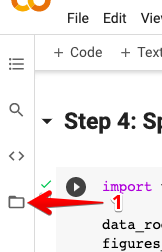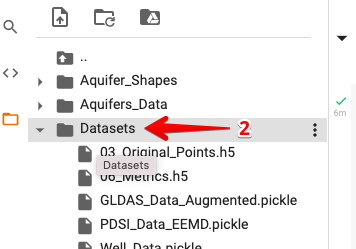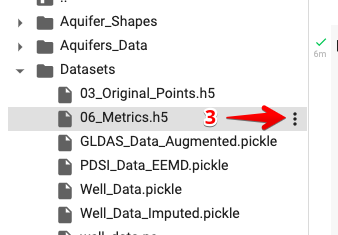

---

---

---

## **Appendix**

In [ ]:
#@markdown <a name="download"></a>
#@markdown ### **Allow Colab to Download Multiple Files**
#@markdown In order to download multiple files at once in Colab, you must allow Colab to do so. 
#@markdown 1. You can run this cell, which will download some small sample data files. 
#@markdown 2. A popup from your browser will appear, asking for permission to download multiple files. You only have to do this once per session. 
#@markdown 3. Afterwards, you can delete the downloaded files.

sample_data = ['/content/sample_data/california_housing_test.csv', 
               '/content/sample_data/california_housing_train.csv', 
               '/content/sample_data/anscombe.json']
for file in sample_data:
  files.download(file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@markdown ### **Open Pickle Files**
# Importing well object class
DA = utils_data_augmentation.Data_Augmentation("/content/", '/content/')

# Load pickle Data
pickFile = "Well_Data" #@param {type:"string"}
Data = DA.read_pickle(pickFile, "/content/")
measurements = Data['Data']

print('Min of measurements: %.2f' %np.nanmin(measurements.values))


In [ ]:
new_imputed = pd.DataFrame(index=Data['Data'].index)
for well in Data['Original'].columns:
  nonan_subset = Data['Original'][well].dropna()
  range = (nonan_subset.index[-1] - nonan_subset.index[0])
  well_subset = Data['Data'][well]
  new_imputed.loc[:,well] = well_subset.loc[
                                      (well_subset.index > (nonan_subset.index[0] - range)) & 
                                      (well_subset.index < (nonan_subset.index[-1] + range))]

In [ ]:
# tms_df_matrix = pd.pivot_table(tms_df, index=date, values=var, columns=tms_wellID)
Data['Location'].to_csv('75obs_well_locations.csv')

measurements_unpivot = pd.DataFrame(measurements.stack()).reset_index()
measurements_final = measurements_unpivot.rename(columns={'level_0':'date', 'level_1':'Well_ID', 0:'WTE'})
measurements_final.to_csv('75obs_well_measurements.csv')
measurements_final

print('total measurements',measurements.count().sum())
print('# of wells', len(measurements_final.drop_duplicates('Well_ID')))

In [ ]:
#@markdown ### **Save pickle file using protocol 3**
with open(pickFile+'pick3.pickle', 'wb') as f2:
    pickle.dump(Data, f2, 3)

In [ ]:
measurements_imputed
flagged = []
for well in measurements_imputed:
  subset = measurements_imputed[well]
  if (subset.max() - subset.min() > 100):
    flagged.append(well)
flagged

outlier_wells = []
for well in measurements.columns:
  subset = measurements[well].dropna()
  diff = subset.diff()
  diff_rate = abs(subset.diff()/subset.index.to_series().diff().dt.days)
  mean_rate = diff_rate.mean()
  if len(subset[diff_rate > mean_rate*5]) > 0 and len(diff[abs(diff) > 50]) > 0:
    outlier_wells.append(well)




other_wells = list(set(flagged) - set(outlier_wells))
other_wells.sort()

y =  73#@param {type:"integer"}
figure(figsize=(10, 6), dpi=80)
plt.plot(measurements_imputed[other_wells[y]])
plt.plot(measurements_raw[other_wells[y]])
plt.legend(['Imputed','Raw'])

In [ ]:
#@markdown ### **Plot all imputed graphs**
data_root, figures_root = '/content/Datasets/', '/content/Figures Imputed'
imputation = utils_machine_learning.imputation(data_root, figures_root)

imputation.Aquifer_Plot(measurements)

In [ ]:
#@markdown ### **Plot wells**
numObs = 50 #@param {type:"integer"}
def toGDF(df, latCol, lonCol):
  gdf = gpd.GeoDataFrame(df.copy(deep=True), geometry=gpd.points_from_xy(df[lonCol], df[latCol]))
  gdf.crs = ('epsg:4326')
  return gdf

def background_map(aquifers, wells):
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # Background map is part of geopandas library
  ax = world.plot(color='white', edgecolor='black')
  minx, miny, maxx, maxy = aquifers.total_bounds
  aquifers.plot(ax=ax, color='royalblue') # Royal Blue Polygons = primary aquifers
  if type(wells) == gpd.geodataframe.GeoDataFrame:
    wells.plot(ax=ax, color='red', markersize=1) # Red dots = wells outside of aquifers
  ax.set_xlim(minx, maxx)
  ax.set_ylim(miny, maxy)
  plt.title('%d Obs - %d wells' %(numObs, len(Locations_df)))
  
aq_gdf = gpd.read_file('/content/Aquifer_Shapes/%s' %aqFile)
Locations_df = Data['Location']
background_map(aq_gdf, toGDF(Locations_df, 'Latitude', 'Longitude'))
plt.savefig('wells.png')

In [ ]:
#@markdown ### **Upload error metrics file and calculate overall metrics**
You may need to ensure that pandas and tables are updated
uploaded = files.upload()
metricsFile = ''.join(uploaded)
all_metrics = pd.read_csv(metricsFile, index_col=0)

train_metrics = ( all_metrics.loc[:,['Train ME', 'Train RMSE', 'Train MAE', 'Train r2']].multiply(all_metrics.loc[:,'Train Points'], axis="index") ).sum() / sum(all_metrics.loc[:,'Train Points'])
val_metrics = ( all_metrics.loc[:,['Validation ME', 'Validation RMSE', 'Validation MAE', 'Validation r2']].multiply(all_metrics.loc[:,'Validation Points'], axis="index") ).sum() / sum(all_metrics.loc[:,'Validation Points'])
test_metrics = ( all_metrics.loc[:,['Test ME', 'Test RMSE', 'Test MAE', 'Test r2']].multiply(all_metrics.loc[:,'Test Points'], axis="index") ).sum() / sum(all_metrics.loc[:,'Test Points'])
comp_r2 = pd.Series(all_metrics.loc[:, 'Comp R2'].mean(), index=['Comp R2'])

sum_metrics_series_norm = pd.concat([train_metrics, val_metrics, test_metrics, comp_r2])
sum_metrics_series_avg = all_metrics.drop(columns=['Train Points', 'Validation Points', 'Test Points']).mean()
summary_metrics = pd.DataFrame([sum_metrics_series_norm, sum_metrics_series_avg], columns=sum_metrics_series_norm.index, index=['Normalized Errors', 'Average Errors'])
summary_metrics

In [ ]:
summary_metrics_iter = pd.DataFrame()
summary_metrics = pd.DataFrame()
for file in sorted(os.listdir('/content/Datasets')):
  if file.startswith("06"):
    if file.endswith("iter.csv"):
      metricsFile = os.path.join('/content/Datasets', file)
      all_metrics = pd.read_csv(metricsFile, index_col=0)
      train_metrics = ( all_metrics.loc[:,['Train ME', 'Train RMSE', 'Train MAE', 'Train r2']].multiply(all_metrics.loc[:,'Train Points'], axis="index") ).sum() / sum(all_metrics.loc[:,'Train Points'])
      val_metrics = ( all_metrics.loc[:,['Validation ME', 'Validation RMSE', 'Validation MAE', 'Validation r2']].multiply(all_metrics.loc[:,'Validation Points'], axis="index") ).sum() / sum(all_metrics.loc[:,'Validation Points'])
      test_metrics = ( all_metrics.loc[:,['Test ME', 'Test RMSE', 'Test MAE', 'Test r2']].multiply(all_metrics.loc[:,'Test Points'], axis="index") ).sum() / sum(all_metrics.loc[:,'Test Points'])
      comp_r2 = pd.Series(all_metrics.loc[:, 'Comp R2'].mean(), index=['Comp R2'])

      sum_metrics_series_norm = pd.concat([train_metrics, val_metrics, test_metrics, comp_r2])
      summary_metrics_iter = summary_metrics_iter.append(
          pd.DataFrame([sum_metrics_series_norm], columns=sum_metrics_series_norm.index, index=[file.split('_')[2].split('-')[0]])
          )
    # summary_metrics_avg = summary_metrics_avg.append(
    #     pd.DataFrame([all_metrics.drop(columns=['Train Points', 'Validation Points', 'Test Points']).mean()], index=[file.split('_')[2].split('.')[0]])
    #     )
    else:
      metricsFile = os.path.join('/content/Datasets', file)
      all_metrics = pd.read_csv(metricsFile, index_col=0)
      train_metrics = ( all_metrics.loc[:,['Train ME', 'Train RMSE', 'Train MAE', 'Train r2']].multiply(all_metrics.loc[:,'Train Points'], axis="index") ).sum() / sum(all_metrics.loc[:,'Train Points'])
      val_metrics = ( all_metrics.loc[:,['Validation ME', 'Validation RMSE', 'Validation MAE', 'Validation r2']].multiply(all_metrics.loc[:,'Validation Points'], axis="index") ).sum() / sum(all_metrics.loc[:,'Validation Points'])
      test_metrics = ( all_metrics.loc[:,['Test ME', 'Test RMSE', 'Test MAE', 'Test r2']].multiply(all_metrics.loc[:,'Test Points'], axis="index") ).sum() / sum(all_metrics.loc[:,'Test Points'])
      comp_r2 = pd.Series(all_metrics.loc[:, 'Comp R2'].mean(), index=['Comp R2'])

      sum_metrics_series_norm = pd.concat([train_metrics, val_metrics, test_metrics, comp_r2])
      summary_metrics = summary_metrics.append(
          pd.DataFrame([sum_metrics_series_norm], columns=sum_metrics_series_norm.index, index=[file.split('_')[2].split('.')[0]])
          )

display(pd.concat({'Sat': summary_metrics}, names=['Imputation Type', 'Observation-months']))
display(pd.concat({'Iter': summary_metrics_iter}, names=['Imputation Type', 'Observation-months']))


summary_metrics_sorted = summary_metrics_iter.loc[['050-iter','075-iter','150-iter']]
summary_metrics_sorted.plot.bar(figsize=(10,6))
plt.savefig('Error_Comparison_iter.svg')
summary_metrics_sorted = summary_metrics.loc[['050','075','150']]
summary_metrics_sorted.plot.bar(figsize=(10,6))
plt.savefig('Error_Comparison.svg')

In [ ]:
combined_df = pd.concat({'Sat': summary_metrics, 'Iter': summary_metrics_iter}, names=['Imputation Type', 'Observation-months'])

not_r2_metrics = ['Train ME', 'Train RMSE',	'Train MAE',	
                  'Validation ME',	'Validation RMSE',	'Validation MAE',	
                  'Test ME',	'Test RMSE',	'Test MAE']
r2_metrics = ['Train r2', 'Validation r2', 'Test r2',	'Comp R2']
obs_thresholds = ['050', '075', '150']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16,12))
for n, thresh in enumerate(obs_thresholds):
  combined_50_df_notr2 = combined_df.xs(thresh, level=1, drop_level=True).loc[:,not_r2_metrics]
  combined_50_df_notr2.transpose().plot.barh(color=["SkyBlue","IndianRed"], title='%s Obs-mon Threshold Errors' %thresh, ax=axes[n,0])
  combined_50_df_r2 = combined_df.xs(thresh, level=1, drop_level=True).loc[:,r2_metrics]
  combined_50_df_r2.transpose().plot.barh(color=["SkyBlue","IndianRed"], title='%s Obs-mon Threshold r2 Scores' %thresh, ax=axes[n,1])

plt.show()
plt.savefig('Error_Comparison.svg')

In [ ]:
#@markdown ### **"Augment" the imputed wells with raw data**
import copy
# Load pickle Data
DA = utils_data_augmentation.Data_Augmentation("/content/", '/content/')
Imputed_Pick_File = "Well_Data_Imputed_iteration_0_1%wells" #@param {type:"string"}
Well_Data = DA.read_pickle(Imputed_Pick_File, "/content/")
Raw_Pick_File = "raw_wells_dict_5_interp" #@param {type:"string"}
raw_wells_dict_5_interp = DA.read_pickle(Raw_Pick_File, "/content/")

well_data_copy = copy.deepcopy(Well_Data)
aligned_df = raw_wells_dict_5_interp['Data'].loc[Well_Data['Data'].index]
aligned_df.loc[:, Well_Data['Data'].columns] = Well_Data['Data'].iloc[:,:]

loop = tqdm(total = len(aligned_df.columns), position = 0, leave = False)
for col in aligned_df.columns:
  well_data_copy['Data'][col] = aligned_df[col][np.abs(aligned_df[col] - aligned_df[col].mean()) <= (3*aligned_df[col].std())]
  well_data_copy['Location'].loc[col] = raw_wells_dict_5_interp['Location'].loc[col]
  loop.update(1)
loop.close()

DA.Save_Pickle(well_data_copy, f'Well_Data_Imputed_iter0_1%wells_aug_25')

Storage Coefficient code

In [ ]:
print('Upload the storage coefficients shapefile (upload shapefiles as zip folders)')
uploaded = files.upload()
sc_file = ''.join(uploaded)
try:
  try: sc_gdf = gpd.read_file(sc_file)
  except: sc_gdf = gpd.read_file(sc_file+'!'+sc_file[0:-4])
except: print("Try zipping your shapefile files into a zip folder directly (instead of zipping the folder that they reside in)")

def saveCol(button):
  global sc_col
  sc_col = SC_widget.value
  print('\rStorage Coefficient column: "%s"' %(sc_col), end='')

sList = sc_gdf.columns
label_widget = widgets.Label(value='Storage Coefficient Column:')
SC_widget = widgets.Dropdown(options=sList, description = "")
button = widgets.Button(description='Save', disabled=False)
button.on_click(saveCol)

print("\n\nPlease select the appropriate headers in your file for storage coefficient")
widgets.VBox([widgets.HBox([label_widget, SC_widget]), button])

Upload the storage coefficients shapefile (upload shapefiles as zip folders)


Saving MULT_extracted_refactored_dissolved.zip to MULT_extracted_refactored_dissolved.zip


Please select the appropriate headers in your file for storage coefficient


Storage Coefficient column: "SY"

In [ ]:
import grids
# Create an instance of grids.TimeSeries
files_list = ['/content/Datasets/well_data.nc']
var = 'tsvalue'
dim_order = ('time', 'lat', 'lon' )
gfs_data_series = grids.TimeSeries(files=files_list, var=var, dim_order=dim_order)

wte_timeseries = gfs_data_series.shape('/content/MULT_extracted_refactored_dissolved.zip', behavior='features', label_attr="OBJECTID")
wte_timeseries

In [ ]:
# This will convert to using the proper crs, print the area as a double check,
#   calculate an area column, then take the dot product of the timeseries values (M x N)
#   and the scalar of the storage coeff value * the area column (N x 1)
test = sc_gdf.to_crs("NAD_1983_Albers")
print(test.loc[test.SY > 0].geometry.area.sum() / 10**6)
# scaled_ts2.loc[:, (scaled_ts2 > 0).any()]
test['Area'] = test.geometry.area

arr_1 = np.array(wte_timeseries.iloc[:,1:])
scalar = np.array(test[sc_col]) * 0.01 * np.array(test['Area'])
final = pd.DataFrame(arr_1 @ scalar) 
# / test['Area'].sum()
final
## NEED to figure out mean. just divide values by the area and you should get it

In [ ]:
# wte_timeseries.iloc[1,1:]
# scaled_ts2 = pd.DataFrame(columns=wte_timeseries.columns[1:], index=wte_timeseries.loc[:,'datetime'])
# for col in wte_timeseries.columns[1:]:
#   scaled_ts2[col] = (wte_timeseries[col] * sc_gdf[sc_gdf.OBJECTID == int(col.split('_')[1])][sc_col].iloc[0]).values * 0.01 * test3[col].Area

# scaled_ts = scaled_ts2.loc[:, (scaled_ts2 > 0).any()] / test3.Area.sum()
# display(scaled_ts)

# Plot storage depletion curve
x_set = pd.Series(scaled_ts.index, dtype=int).apply(lambda x: datetime.datetime.fromordinal(x-1)) # Convert from days since 0001-01-01 00:00:00
y_set = (final.iloc[0:] - final.iloc[0])[0] / 10**6 / area_coeff / vol_coeff / .3048**2
# y_set = (scaled_ts.iloc[0:] - scaled_ts.iloc[0]).mean(axis=1) * area / 10**6 / area_coeff / vol_coeff
df_st_dep = pd.DataFrame(y_set, columns={'Storage_Change'}).set_index(x_set)
plt.plot(x_set, y_set)
plt.xlabel("Year")
plt.ylabel("Drawdown Volume (%s)" %(vol_lab))
plt.title("Storage Depletion Curve (storage coeff = %.2f)\n%s" %(storage_coefficient, plot_title_params))
plt.savefig('/content/Datasets/storage_depletion_%.2f.png' %(storage_coefficient))
plt.show()

  

In [ ]:
x3 = x_set[start_index:]
y3 = ( df_st_dep.iloc[start_index:] - df_st_dep.iloc[start_index] ) * 10**6 * area_coeff / area * (0.3048/unit_coeff) * 100 # water level equivalent in cm
df3 = pd.DataFrame(y3).rename(columns={'Storage_Change':'Imputed Data'})

ax = df3.plot(figsize=(10, 5), xlabel='Year', ylabel="Liquid Water Equivalent Thickness (cm)",
                title='Comparison to GRACE%s\n%s, storage coeff=%.2f' %('sometitle', plot_title_params, storage_coefficient))
(df2*5).plot(y=0, ax=ax, linestyle='-')

In [ ]:
NEED to compare this one vs. the points one (it is roughly equivalent)
found out the array dot product works; grid cells shapefile seems plots well; the dissolved one got the same results

In [ ]:
# Points code
## Convert the geometry and appropriate columns
sc_gdf_pts = gpd.GeoDataFrame(sc_gdf[['CELLNUM', 'SY']], geometry=sc_gdf.centroid)
sc_gdf_pts_trim = sc_gdf_pts.loc[sc_gdf_pts.SY > 0]
sc_gdf_pts_trim.loc[:,'time'] = None
sc_gdf_pts_trim = sc_gdf_pts_trim.to_crs(4326)
sc_gdf_pts_trim.loc[:, 'lon'], sc_gdf_pts_trim.loc[:, 'lat'] = sc_gdf_pts_trim.geometry.x, sc_gdf_pts_trim.geometry.y

## Trim gdf to proper range
lat_range = (-90,90)
lon_range = (-180, 180)
sc_gdf_pts_trim_inrange = sc_gdf_pts_trim[(sc_gdf_pts_trim.lon > lon_range[0]) & (sc_gdf_pts_trim.lon < lon_range[1])]
sc_gdf_pts_trim_inrange = sc_gdf_pts_trim_inrange[(sc_gdf_pts_trim.lat > lat_range[0]) & (sc_gdf_pts_trim.lat < lat_range[1])]

## Convert to usable tuple
coordinates_list = [
    tuple(i) for i in sc_gdf_pts_trim_inrange[['time', 'lat', 'lon']].values
]
labels = sc_gdf_pts_trim_inrange['CELLNUM'].to_list()

## Use grids to query values at points
import grids
# Create an instance of grids.TimeSeries
files_list = ['/content/Datasets/well_data_sat.nc']
var = 'tsvalue'
dim_order = ('time', 'lat', 'lon' )
gfs_data_series = grids.TimeSeries(files=files_list, var=var, dim_order=dim_order)

wte_forecast = gfs_data_series.multipoint(*coordinates_list, labels=labels)
wte_forecast

## Multiply arrays to get the final values
arr_1 = np.array(wte_forecast.iloc[:,1:])
arr_1[np.isnan(arr_1)] = 0
display(arr_1)
num_pts = len(wte_forecast.dropna(axis=1).iloc[0])
scalar = np.array(sc_gdf_pts_trim_inrange[sc_col]) * 0.01
final = pd.DataFrame(arr_1 @ scalar) / num_pts
final

## Convert and plot results in terms of ac-ft
x_set = pd.Series(wte_forecast.datetime, dtype=int).apply(lambda x: datetime.datetime.fromordinal(x-1)) # Convert from days since 0001-01-01 00:00:00
y_set = (final.iloc[0:] - final.iloc[0])[0] * area / 10**6 / area_coeff / vol_coeff

plt.plot(x_set, y_set, color='red')
plt.plot(x_data, y_data)

Pdf plotting

In [ ]:
def test_plot(Data, name):
  fig = plt.figure()
  y = np.array(list(history.history.values())).T
  plt.plot(list(range(len(y))), y)
  plt.grid(True)
  plt.gca().set_ylim(-0.5, 5)
  # plt.savefig(self.figures_root + '/' + name + '_Training_History')
  return fig

from matplotlib.backends.backend_pdf import PdfPages

pp = PdfPages('Save multiple plots as PDF.pdf')
for i in range(10):
  fig1 = test_plot(history.history, str(well))
  pp.savefig(fig1)

# pp.close()



In [ ]:
###### Model Plots
# imputation.Model_Training_Metrics_plot(history.history, str(well))
# imputation.Q_Q_plot(y_val_hat, y_val, str(well), limit_low = y_val.min()[0], limit_high = y_val.max()[0])
# imputation.observeation_vs_prediction_plot(Prediction.index, Prediction['Prediction'], Well_set_original.index, Well_set_original, str(well), Summary_Metrics.loc[well], error_on = True)
# imputation.residual_plot(Prediction.index, Prediction['Prediction'], Well_set_original.index, Well_set_original, str(well))
# imputation.observeation_vs_imputation_plot(Imputed_Data.loc[Prediction.index].index, Imputed_Data.loc[Prediction.index][well], Well_set_original.index, Well_set_original, str(well))
# imputation.raw_observation_vs_prediction(Prediction, Raw, str(well), aquifer_name, Summary_Metrics.loc[well], error_on = True)
# imputation.raw_observation_vs_imputation(Filled_time_series, Raw, str(well), aquifer_name)
# imputation.observeation_vs_prediction_scatter_plot(Prediction['Prediction'], y_train, y_val, str(well), Summary_Metrics.loc[well], error_on = True)


def Model_Training_Metrics_plot(Data, name, show=False):
        fig_hist = plt.figure()
        for key in Data: plt.plot(Data[key])
        plt.grid(True)
        plt.gca().set_ylim(-0.5, 5)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(Data.keys())
        plt.savefig(figures_root + '/' + name + '_Training_History')
        if show: plt.show()
        else: plt.close(fig_hist) 
        return fig_hist

        
def Q_Q_plot(Prediction, Observation, name, limit_low = 0, limit_high = 1, extension = '.png', show=False):
        #Plotting Prediction Correlation
        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        plt.scatter(Prediction, Observation)
        plt.ylabel('Observation')
        plt.xlabel('Prediction')
        plt.legend(['Prediction', 'Observation'])
        plt.title('Prediction Correlation: ' + name)
        cor_line_x = np.linspace(limit_low, limit_high, 9)
        cor_line_y = cor_line_x
        plt.xlim(limit_low, limit_high)
        plt.ylim(limit_low, limit_high)
        plt.plot(cor_line_x, cor_line_y, color='r')
        ax1.set_aspect('equal', adjustable='box')
        plt.savefig(figures_root + '/' + name + '_01_Q_Q' + extension)
        if show: plt.show()
        else: plt.close(fig1) 
        return fig1
        

def observeation_vs_prediction_plot(Prediction_X, Prediction_Y, Observation_X, Observation_Y, name, metrics=None, error_on = False, show=False):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
        ax.plot(Prediction_X, Prediction_Y, "darkblue")
        # Potential bug # pandas version 1.4 pandas.errors.InvalidIndexError: (slice(None, None, None), None)
        ax.plot(Observation_X, Observation_Y, label= 'Observations', color='darkorange')
        ax.set_ylabel('Groundwater Surface Elevation')
        ax.legend(['Prediction', 'Observation'])
        ax.set_title('Observation Vs Prediction: ' + name)
        if error_on:
          ax.text(x=0.0, y=-0.15, s = metrics[['Train ME','Train RMSE', 'Train MAE', 'Train r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
          ax.text(x=0.25, y=-0.15, s = metrics[['Validation ME','Validation RMSE', 'Validation MAE', 'Validation r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)          
          extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
          fig.savefig(figures_root  + '/' + name + '_02_Observation', bbox_inches=extent.expanded(1.1, 1.6))
        else: fig.savefig(figures_root  + '/' + name + '_02_Observation')
        if show: plt.show()
        else: plt.close(fig)
        return fig

def residual_plot(Prediction_X, Prediction_Y, Observation_X, Observation_Y, name, show=False):
        data = Data_Join(Prediction_Y, Observation_Y).dropna()
        data.columns = ['Prediction_Y', 'Observation_Y']
        fig3 = plt.figure(figsize=(12, 8))
        plt.plot(data.index, data['Prediction_Y'] - data['Observation_Y'], marker = 'o', linestyle='None', color = "black")
        plt.ylabel('Prediction Residual Error')
        plt.title('Residual Error: ' + name)
        plt.plot(data.index, np.zeros(shape = (len(data.index), 1)), color = 'royalblue', linewidth= 4.0)
        plt.savefig(figures_root  + '/' + name + '_03_Residual_Plot')
        if show: plt.show()
        else: plt.close(fig3)
        return fig3

def observeation_vs_imputation_plot(Prediction_X, Prediction_Y, Observation_X, Observation_Y, name, show=False):
        fig4 = plt.figure(figsize=(12, 8))
        plt.plot(Prediction_X, Prediction_Y, "darkblue")
        plt.plot(Observation_X, Observation_Y, label= 'Observations', color='darkorange')
        plt.ylabel('Groundwater Surface Elevation')
        plt.xlabel('Date')
        plt.legend(['Imputed Values', 'Smoothed Observations'])
        plt.title('Observation Vs Imputation: ' + name)
        plt.savefig(figures_root  + '/' + name + '_04_Imputation')
        if show: plt.show()
        else: plt.close(fig4)
        return fig4

def raw_observation_vs_prediction(Prediction, Raw, name, Aquifer, metrics=None, error_on = False, test=False, show=False):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
        ax.plot(Prediction.index, Prediction, 'darkblue', label='Prediction', linewidth=1.0)
        ax.scatter(Raw.index, Raw, color='darkorange', marker = '*', s=10, label= 'Observations')
        ax.set_title(Aquifer + ': ' + 'Well: ' + name + ' Raw vs Prediction')
        ax.legend(fontsize = 'x-small')
        if error_on:
          ax.text(x=0.0, y=-0.15, s = metrics[['Train ME','Train RMSE', 'Train MAE', 'Train r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
          ax.text(x=0.25, y=-0.15, s = metrics[['Validation ME','Validation RMSE', 'Validation MAE', 'Validation r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)          
          extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
          if test:
               ax.text(x=0.5, y=-0.15, s = metrics[['Test ME','Test RMSE', 'Test MAE', 'Test r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
          fig.savefig(figures_root  + '/' + name + '_05_Prediction_vs_Raw', bbox_inches=extent.expanded(1.1, 1.6))
        else: fig.savefig(figures_root  + '/' + name + '_05_Prediction_vs_Raw')
        if show: plt.show()
        else: plt.close(fig)
        return fig

def observeation_vs_prediction_scatter_plot( Prediction, Y_train, Y_val, name, metrics=None, error_on = False, show=False):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
        ax.plot(Prediction.index, Prediction, "darkblue", linewidth=1.0)
        ax.scatter(Y_train.index, Y_train, color='darkorange', marker='*', s=10)
        ax.scatter(Y_val.index, Y_val, color='lightgreen', s=10)  
        ax.legend(['Prediction', 'Training Data', 'Validation Data'])
        ax.set_ylabel('Groundwater Surface Elevation')
        ax.set_title('Observation Vs Prediction: ' + name)
        if error_on:
          ax.text(x=0.0, y=-0.15, s = metrics[['Train ME','Train RMSE', 'Train MAE', 'Train r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
          ax.text(x=0.25, y=-0.15, s = metrics[['Validation ME','Validation RMSE', 'Validation MAE', 'Validation r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)          
          extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
          fig.savefig(figures_root  + '/' + name + '_07_Observation', bbox_inches=extent.expanded(1.2, 1.6))
        else: fig.savefig(figures_root  + '/' + name + '_07_Observation')
        if show: plt.show()
        else: plt.close(fig)
        return fig

def prediction_vs_test_kfold(Prediction, Well_set_original, name, metrics=None, error_on = False, show=False):
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111)
        ax.plot(Prediction.index, Prediction, "darkblue", linewidth=1.0)
        ax.scatter(Well_set_original.index, Well_set_original, color='darkorange', marker='*', s=10)
        ax.set_ylabel('Groundwater Surface Elevation')
        ax.legend(['Prediction', 'Training Data', 'Test Data'])
        ax.set_title('Observation Vs Prediction: ' + name)
        if error_on:
          ax.text(x=0.0, y=-0.15, s = metrics[['Train ME','Train RMSE', 'Train MAE', 'Train r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
          ax.text(x=0.25, y=-0.15, s = metrics[['Validation ME','Validation RMSE', 'Validation MAE', 'Validation r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)  
          ax.text(x=0.5, y=-0.15, s = metrics[['Test ME','Test RMSE', 'Test MAE', 'Test r2']].to_string(index=True, float_format = "{0:.3}".format),
                  fontsize = 12, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)
          extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
          fig.savefig(figures_root  + '/' + name + '_08_Test_kfold', bbox_inches=extent.expanded(1.2, 1.6))
        else: fig.savefig(figures_root  + '/' + name + '_08_Test_kfold')
        if show: plt.show()
        else: plt.close(fig)
        return fig

from matplotlib.backends.backend_pdf import PdfPages

pp = PdfPages('Save multiple plots as PDF.pdf')


In [ ]:
if Validation_Type[0] == '1':
    # imp.Q_Q_plot(y_val_hat, y_val, str(well), limit_low = y_val.min()[0], limit_high = y_val.max()[0])
    # imp.observeation_vs_prediction_plot(Prediction.index, Prediction['Prediction'], y_well.index, y_well, str(well), Summary_Metrics.loc[well], error_on = True)
    # imp.observeation_vs_imputation_plot(Imputed_Data.loc[Prediction.index].index, Imputed_Data.loc[Prediction.index][well], y_well.index, y_well, str(well))
    # imp.raw_observation_vs_imputation(Filled_time_series, y_raw, str(well), aquifer_name)
    # imp.observeation_vs_prediction_scatter_plot(Prediction['Prediction'], y_train, y_val, str(well), Summary_Metrics.loc[well], error_on = True)
    fig2 = Q_Q_plot(y_val_hat, y_val, str(well), limit_low = y_val.min()[0], limit_high = y_val.max()[0])
    pp.savefig(fig2)
    fig3 = observeation_vs_prediction_plot(Prediction.index, Prediction['Prediction'], y_well.index, y_well, str(well), Summary_Metrics.loc[well], error_on = True)
    pp.savefig(fig3)
    fig5 = observeation_vs_imputation_plot(Imputed_Data.loc[Prediction.index].index, Imputed_Data.loc[Prediction.index][well], y_well.index, y_well, str(well))
    pp.savefig(fig5)
    fig7 = raw_observation_vs_imputation(Filled_time_series, y_raw, str(well), aquifer_name)
    pp.savefig(fig7)
    fig8 = observeation_vs_prediction_scatter_plot(Prediction['Prediction'], y_train, y_val, str(well), Summary_Metrics.loc[well], error_on = True)
    pp.savefig(fig8)
if Validation_Type[0] == '2':
    # imp.prediction_vs_test_kfold(Prediction['Prediction'], y_well, str(well), Summary_Metrics.loc[well], error_on = True)
    fig9 = prediction_vs_test_kfold(Prediction['Prediction'], y_well, str(well), Summary_Metrics.loc[well], error_on = True)
    pp.savefig(fig9)
# imp.raw_observation_vs_prediction(Filled_time_series, y_raw, str(well), aquifer_name, Summary_Metrics.loc[well], error_on = True, test=True) 
# imp.residual_plot(Prediction.index, Prediction['Prediction'], y_well.index, y_well, str(well))
# imp.Model_Training_Metrics_plot(history.history, str(well))
fig6 = raw_observation_vs_prediction(Filled_time_series, y_raw, str(well), aquifer_name, Summary_Metrics.loc[well], error_on = True, test=True) 
pp.savefig(fig6)
fig4 = residual_plot(Prediction.index, Prediction['Prediction'], y_well.index, y_well, str(well))
pp.savefig(fig4)
fig1 = Model_Training_Metrics_plot(history.history, str(well))
pp.savefig(fig1)

In [ ]:
import sys
objects=[]
for name,obj in locals().items():
   objects.append([name,sys.getsizeof(obj)])
sorted(objects,key=lambda x: x[1],reverse=True)

In [ ]:
import os

def mem_report(df=pd.DataFrame(), well=0, line='None', prev_percent=0):
  # Getting all memory using os.popen()
  total_memory, used_memory, free_memory = map(
      int, os.popen('free -t -m').readlines()[-1].split()[1:])
    
  mem_percent = round((used_memory/total_memory) * 100, 5)
  df.loc[well, line] = mem_percent - prev_percent
  return mem_percent

memory_tracker = pd.DataFrame(index=Well_Data['Data'].columns)

In [ ]:
361334120035101

In [ ]:
import os
file_dir = '/content/Figures Imputed'
for file in os.listdir(file_dir):
  # if file.startswith("GRACE"):
  os.remove(os.path.join(file_dir, file))